<a href="https://colab.research.google.com/github/iknm/Data-scince/blob/main/cognitive_prediction_assessments_and_ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Loading up all the libraries needed.

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D, Input, Conv1D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD, Adam
import gzip
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import train_test_split, learning_curve, validation_curve, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform

import sys, os
import numpy as np
from scipy import fftpack, signal

%matplotlib inline


import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense

from numpy.random import randn
from matplotlib import pyplot

# Load data ( previsoly saved )

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define paths to load your DataFrames
df2_path = '/content/drive/My Drive/DF2.pkl'
df1_path = '/content/drive/My Drive/DF1.pkl'

# Load the saved DataFrames
DF2 = pd.read_pickle(df2_path)
DF1 = pd.read_pickle(df1_path)

print("DF2 and DF1 have been loaded from Google Drive.")


Mounted at /content/drive
DF2 and DF1 have been loaded from Google Drive.


In [ ]:
import pandas as pd

# The names and stages from your table
name_stage_mapping = {
    'Tome': 1, 'Tom': 1, 'Clarc': 1, 'Michelle': 1, 'Roy': 0, 'Patty': 2, 'Patrich': 2, 'Shella': 4, 'Paul': 3, 'Bob': 3,
    'Jennifer': 2, 'Dallas': 0, 'Kathy': 3, 'Tomebo': 1, 'Bonnie': 1, 'James': 3, 'Cindy Conte': 0,
    'Becky': 0, 'Bernice': 0, 'Chuck': 0, 'JudyT': 0, 'LindaB': 0, 'LindaG': 0, 'Pam': 0, 'Shirley': 0, 'Casey': 1,
    'Gary': 4, 'Gene': 4, 'Jane': 2, 'Joe': 2, 'Keith': 1, 'Kurt': 1, 'Larry': 4, 'Paul': 1, 'Aileenev': 1,
    'Johnevens': 1, 'Jane Snodgrass': 2, 'Kathapp': 1, 'Clime3-k': 0, 'Kennth': 4
}

# Mapping based on names from DF2 (spelling preserved)
df2_names = ['Clime3-k', 'Kathapp', 'Kennth', 'Patty', 'Patrich', 'Paul', 'Shella', 'Tom', 'Tome', 'Tomebo',
             'Clarc', 'Michelle', 'Roy', 'Aileenev', 'Johnevens', 'Dallas', 'Bob', 'Bonnie', 'James',
             'Jane', 'Jennifer', 'Kathy']

# Function to map names from DF2 to names in the table
def get_stage(name):
    # Clean and match names as best as possible
    cleaned_name = name.strip()

    # Exact match
    if cleaned_name in name_stage_mapping:
        return name_stage_mapping[cleaned_name]

    # If name is not found, ask the user
    else:
        print(f"Uncertain about the stage for {cleaned_name}.")
        return None  # This can be changed to request input if necessary

# Add a "Stage" column to DF2
DF2['Stage'] = DF2['Name'].apply(get_stage)

# Check for rows with NaN stages
missing_stage_rows = DF2[DF2['Stage'].isna()]

if not missing_stage_rows.empty:
    print("\nRows with missing stages:")
    print(missing_stage_rows[['Name', 'Stage']])
else:
    print("\nNo missing stages found.")

# Show the dataframe with the new column (without dropping duplicates)
print(DF2[['Name', 'Stage']])




No missing stages found.
            Name  Stage
0       Clime3-k      0
1       Clime3-k      0
2       Clime3-k      0
3       Clime3-k      0
4       Clime3-k      0
...          ...    ...
905299     Clarc      1
905300     Clarc      1
905301     Clarc      1
905302     Clarc      1
905303     Clarc      1

[905304 rows x 2 columns]


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define the extra info DataFrame
extra_info = pd.DataFrame({
     'Subject': ['Becky', 'Bernice', 'Chuck', 'Cindy', 'JudyT', 'LindaB', 'LindaG', 'Pam', 'Shirley',
                'Casey', 'Gary', 'Gene', 'Janice', 'Joe', 'Keith', 'Kurt', 'Larry', 'Paul', 'michelle',
                'clarc', 'roy', 'patty', 'Paul', 'bob', 'kathy', 'tome', 'bonnie', 'james', 'dallas'],
    'PD': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 4, 2, 2, 1, 1, 4, 1, 1, 1, 0, 2, 3, 3, 3, 1, 1, 3, 0],

})

# Merge with the existing data
DF11 = DF1.merge(extra_info, left_on='subject', right_on='Subject')
DF11.drop(columns=['Subject'], inplace=True)

In [ ]:
# Group dataframes by subject name and segment
grouped_df = DF11.groupby(['subject', 'segment', 'task', 'side'])

In [ ]:
import pandas as pd

# Drop the first 'Unnamed: 0' column in DF2
DF2 = DF2.drop(columns=['Unnamed: 0'])

# Rename 'Name' in DF2 to 'subject' to match DF11
DF2 = DF2.rename(columns={'Name': 'subject'})

# Standardize 'Task' column in DF2 to use numbers instead of words
DF2['Task'] = DF2['Task'].replace({'task one': 1, 'task two': 2})

# Add 'Category' column to DF11 and set it to 'toe' for all rows since DF11 is all toe-tapping data
DF11['Category'] = 'toe'

# Rename 'Stage' in DF2 to 'PD' to match DF11, assuming 0 for HC and 1-4 for PD stages
DF2 = DF2.rename(columns={'Stage': 'PD'})

# Ensure 'PD' in both dataframes uses the same values: 0 for HC, and 1-4 for PD stages
# (Optional: if you want to ensure PD values align with specific mapping)
# For instance, if DF2 uses any different encoding, you can adjust here.


# Verify the changes by displaying the column names for both dataframes
print("DF11 Columns After Standardization:", DF11.columns)
print("DF2 Columns After Standardization:", DF2.columns)


DF11 Columns After Standardization: Index(['heel_x_filter', 'heel_y_filter', 'heel_z_filter', 'toe_x_filter',
       'toe_y_filter', 'toe_z_filter', 'heel_std', 'toe_std', 'subject',
       'segment', 'side', 'task', 'PD', 'Category'],
      dtype='object')
DF2 Columns After Standardization: Index(['Heel_x', 'Heel_y', 'Heel_z', 'Toe_x', 'Toe_y', 'Toe_z', 'Heel_Acc',
       'Toe_Acc', 'subject', 'Task', 'Category', 'Segment', 'Side', 'PD'],
      dtype='object')


<ipython-input-6-59ec8af80273>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  DF2['Task'] = DF2['Task'].replace({'task one': 1, 'task two': 2})


In [ ]:
# Rename columns in DF11 to match DF2 naming
DF11 = DF11.rename(columns={
    'heel_x_filter': 'Heel_x',
    'heel_y_filter': 'Heel_y',
    'heel_z_filter': 'Heel_z',
    'toe_x_filter': 'Toe_x',
    'toe_y_filter': 'Toe_y',
    'toe_z_filter': 'Toe_z',
    'heel_std': 'Heel_Acc',
    'toe_std': 'Toe_Acc',
    'task': 'Task',
    'side': 'Side',
    'segment': 'Segment'
})

# Check the updated column names
print("Updated DF11 Columns:")
print(DF11.columns)


Updated DF11 Columns:
Index(['Heel_x', 'Heel_y', 'Heel_z', 'Toe_x', 'Toe_y', 'Toe_z', 'Heel_Acc',
       'Toe_Acc', 'subject', 'Segment', 'Side', 'Task', 'PD', 'Category'],
      dtype='object')


In [ ]:
# Check the size, rows, columns, and column names for DF11
print("DF11 Info:")
print(f"Number of rows in DF11: {DF11.shape[0]}")
print(f"Number of columns in DF11: {DF11.shape[1]}")
print("Column names in DF11:")
print(DF11.columns.tolist())
print("\n")

# Check the size, rows, columns, and column names for DF2
print("DF2 Info:")
print(f"Number of rows in DF2: {DF2.shape[0]}")
print(f"Number of columns in DF2: {DF2.shape[1]}")
print("Column names in DF2:")
print(DF2.columns.tolist())


DF11 Info:
Number of rows in DF11: 457547
Number of columns in DF11: 14
Column names in DF11:
['Heel_x', 'Heel_y', 'Heel_z', 'Toe_x', 'Toe_y', 'Toe_z', 'Heel_Acc', 'Toe_Acc', 'subject', 'Segment', 'Side', 'Task', 'PD', 'Category']


DF2 Info:
Number of rows in DF2: 905304
Number of columns in DF2: 14
Column names in DF2:
['Heel_x', 'Heel_y', 'Heel_z', 'Toe_x', 'Toe_y', 'Toe_z', 'Heel_Acc', 'Toe_Acc', 'subject', 'Task', 'Category', 'Segment', 'Side', 'PD']


In [ ]:
import numpy as np
import pandas as pd
from scipy import signal

# Define sensor headers based on the actual column names in DF11 and DF2
headers = ['Heel_x', 'Heel_y', 'Heel_z', 'Toe_x', 'Toe_y', 'Toe_z', 'Heel_Acc', 'Toe_Acc']

# Define new column headers for each feature set
time_domain_features = ['mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurt', 'q25', 'q75']
headers_time_domain = [f'{header}_{feature}' for feature in time_domain_features for header in headers]

headers_rms = [f'{header}_rms' for header in headers]
headers_zcr = [f'{header}_zcr' for header in headers]
headers_dfi = [f'{header}_dominant_freq_index' for header in headers]
headers_dfm = [f'{header}_dominant_freq_magnitude' for header in headers]

# Combine all headers into one features header list
features_headers = headers_time_domain + headers_rms + headers_zcr + headers_dfi + headers_dfm

# Function to process each segment and extract features
def process_segment(group, headers):
    # Extract subject info
    subject = group['subject'].iloc[0]
    segment = group['Segment'].iloc[0]
    side = group['Side'].iloc[0]
    task = group['Task'].iloc[0]
    PD = group['PD'].iloc[0]
    category = group['Category'].iloc[0]  # Extract the Category (heel or toe)

    # Keep only relevant numeric columns
    numeric_group = group[headers]

    # Time-domain features
    mean = numeric_group.mean().to_numpy()
    median = numeric_group.median().to_numpy()
    std = numeric_group.std().to_numpy()
    min_value = numeric_group.min().to_numpy()
    max_value = numeric_group.max().to_numpy()
    range_value = max_value - min_value
    skewness = numeric_group.skew().to_numpy()
    kurtosis = numeric_group.kurt().to_numpy()
    q25 = numeric_group.quantile(0.25).to_numpy()
    q75 = numeric_group.quantile(0.75).to_numpy()

    # Root Mean Square (RMS) value
    rms = np.sqrt(np.mean(np.square(numeric_group), axis=0))

    # Zero-crossing rate
    zero_crossing_rate = (numeric_group.apply(np.sign).diff().abs().sum(axis=0)) / (2 * len(numeric_group))

    # Power Spectral Density (PSD)
    freqs, psd_data = signal.welch(numeric_group, axis=0)

    # Dominant frequency and its magnitude
    dominant_freq_index = np.argmax(psd_data, axis=0)
    dominant_freq_magnitude = np.max(psd_data, axis=0)

    # Concatenate all features
    features = np.concatenate([
        mean, median, std, min_value, max_value, range_value, skewness, kurtosis, q25, q75,
        rms, zero_crossing_rate,
        dominant_freq_index, dominant_freq_magnitude
    ])

    # Debug: Ensure the correct length of features
    assert len(features) == len(features_headers), f"Mismatch: {len(features)} features, expected {len(features_headers)}"

    return subject, segment, side, task, PD, category, features

# Process DF11 (renamed as DF1F)
grouped_df11 = DF11.groupby(['subject', 'Segment', 'Task', 'Side', 'Category'])
processed_segments_df11 = grouped_df11.apply(lambda group: process_segment(group, headers))

DF1F = pd.DataFrame(
    [(subject, segment, side, task, PD, category, *features) for subject, segment, side, task, PD, category, features in processed_segments_df11.values],
    columns=['subject', 'segment', 'side', 'task', 'PD', 'Category'] + features_headers
)

# Process DF2 (renamed as DF2F)
grouped_df2 = DF2.groupby(['subject', 'Segment', 'Task', 'Side', 'Category'])
processed_segments_df2 = grouped_df2.apply(lambda group: process_segment(group, headers))

DF2F = pd.DataFrame(
    [(subject, segment, side, task, PD, category, *features) for subject, segment, side, task, PD, category, features in processed_segments_df2.values],
    columns=['subject', 'segment', 'side', 'task', 'PD', 'Category'] + features_headers
)

# Display the first few rows of each processed DataFrame
print("DF1F (Features from DF11):")
print(DF1F.head())

print("\nDF2F (Features from DF2):")
print(DF2F.head())


/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 176, using nperseg = 176
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 252, using nperseg = 252
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 184, using nperseg = 184
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWa

DF1F (Features from DF11):
  subject segment   side task  PD Category  Heel_x_mean  Heel_y_mean  \
0   Becky       1   left    1   0      toe     0.073623     0.337223   
1   Becky       1  right    1   0      toe    -0.119100     0.352870   
2   Becky       1   left    2   0      toe     0.068482     0.335187   
3   Becky       1  right    2   0      toe    -0.124356     0.353373   
4   Becky       2   left    1   0      toe     0.069659     0.335527   

   Heel_z_mean  Toe_x_mean  ...  Heel_Acc_dominant_freq_index  \
0     1.249007    0.082696  ...                           2.0   
1     1.314284   -0.090698  ...                           4.0   
2     1.248870    0.082084  ...                           8.0   
3     1.311113   -0.094245  ...                           3.0   
4     1.251198    0.083021  ...                           4.0   

   Toe_Acc_dominant_freq_index  Heel_x_dominant_freq_magnitude  \
0                          2.0                        0.014164   
1                

<ipython-input-9-91e0d8a6e2c7>:81: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  processed_segments_df2 = grouped_df2.apply(lambda group: process_segment(group, headers))


In [ ]:
from scipy.stats import entropy

def add_new_features(df_features, df_raw, headers, source_label='DF'):
    new_data = []

    for idx, row in df_features.iterrows():
        match = (
            (df_raw['subject'] == row['subject']) &
            (df_raw['Segment'] == row['segment']) &
            (df_raw['Task'] == row['task']) &
            (df_raw['Side'] == row['side']) &
            (df_raw['Category'] == row['Category'])
        )
        segment = df_raw[match]

        if segment.empty:
            print(f"[{source_label}] Skipping empty segment at row {idx}")
            continue

        row_features = []

        for col in headers:
            x = segment[col].to_numpy()

            # --- Variability Features ---
            mad = np.mean(np.abs(x - np.mean(x)))
            iqr = np.percentile(x, 75) - np.percentile(x, 25)
            cv = np.std(x) / np.mean(x) if np.mean(x) != 0 else 0

            # --- Hjorth Parameters ---
            dx = np.diff(x)
            ddx = np.diff(dx)
            var_x = np.var(x)
            var_dx = np.var(dx)
            var_ddx = np.var(ddx)
            activity = var_x
            mobility = np.sqrt(var_dx / var_x) if var_x != 0 else 0
            complexity = (np.sqrt(var_ddx / var_dx) / mobility) if var_dx != 0 and mobility != 0 else 0

            # --- Spectral Rhythm Features ---
            freqs, psd = signal.welch(x, fs=50)
            psd_norm = psd / (np.sum(psd) + 1e-8)
            spectral_entropy = entropy(psd_norm)
            spectral_centroid = np.sum(freqs * psd_norm)
            band_energy = np.sum(psd[(freqs >= 0.5) & (freqs < 3)])

            row_features.extend([
                mad, iqr, cv,
                activity, mobility, complexity,
                spectral_entropy, spectral_centroid, band_energy
            ])

        new_data.append(row_features)

    # Create column names
    feature_suffixes = [
        'mad', 'iqr', 'cv',
        'hjorth_activity', 'hjorth_mobility', 'hjorth_complexity',
        'spectral_entropy', 'spectral_centroid', 'spectral_band_energy'
    ]
    new_columns = [f'{col}_{suffix}' for suffix in feature_suffixes for col in headers]

    # Create DataFrame with new features
    new_df = pd.DataFrame(new_data, columns=new_columns)

    # Align index
    new_df.index = df_features.index[:len(new_df)]

    # Combine with original features
    df_combined = pd.concat([df_features.loc[new_df.index].reset_index(drop=True), new_df.reset_index(drop=True)], axis=1)
    return df_combined

# ✅ Apply the working version
DF1F = add_new_features(DF1F, DF11, headers, source_label='DF11')
DF2F = add_new_features(DF2F, DF2, headers, source_label='DF2')

# ✅ Show confirmation
print("DF1F shape:", DF1F.shape)
print("DF2F shape:", DF2F.shape)
print("New columns added:", [col for col in DF1F.columns if any(s in col for s in ['mad', 'hjorth', 'spectral'])])


/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 176, using nperseg = 176
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 252, using nperseg = 252
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 184, using nperseg = 184
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:600: UserWa

DF1F shape: (937, 190)
DF2F shape: (1449, 190)
New columns added: ['Heel_x_mad', 'Heel_y_mad', 'Heel_z_mad', 'Toe_x_mad', 'Toe_y_mad', 'Toe_z_mad', 'Heel_Acc_mad', 'Toe_Acc_mad', 'Heel_x_hjorth_activity', 'Heel_y_hjorth_activity', 'Heel_z_hjorth_activity', 'Toe_x_hjorth_activity', 'Toe_y_hjorth_activity', 'Toe_z_hjorth_activity', 'Heel_Acc_hjorth_activity', 'Toe_Acc_hjorth_activity', 'Heel_x_hjorth_mobility', 'Heel_y_hjorth_mobility', 'Heel_z_hjorth_mobility', 'Toe_x_hjorth_mobility', 'Toe_y_hjorth_mobility', 'Toe_z_hjorth_mobility', 'Heel_Acc_hjorth_mobility', 'Toe_Acc_hjorth_mobility', 'Heel_x_hjorth_complexity', 'Heel_y_hjorth_complexity', 'Heel_z_hjorth_complexity', 'Toe_x_hjorth_complexity', 'Toe_y_hjorth_complexity', 'Toe_z_hjorth_complexity', 'Heel_Acc_hjorth_complexity', 'Toe_Acc_hjorth_complexity', 'Heel_x_spectral_entropy', 'Heel_y_spectral_entropy', 'Heel_z_spectral_entropy', 'Toe_x_spectral_entropy', 'Toe_y_spectral_entropy', 'Toe_z_spectral_entropy', 'Heel_Acc_spectral_ent

In [ ]:
DF2F

,subject,segment,side,task,PD,Category,Heel_x_mean,Heel_y_mean,Heel_z_mean,Toe_x_mean,...,Heel_Acc_spectral_centroid,Toe_Acc_spectral_centroid,Heel_x_spectral_band_energy,Heel_y_spectral_band_energy,Heel_z_spectral_band_energy,Toe_x_spectral_band_energy,Toe_y_spectral_band_energy,Toe_z_spectral_band_energy,Heel_Acc_spectral_band_energy,Toe_Acc_spectral_band_energy
0,Aileenev,1,left,1,1,heel,0.328142,0.379987,0.328125,0.381356,...,0.000000,0.000193,0.000268,0.000408,6.616589e-08,0.632697,0.935490,0.898662,2.065415,0.000000
1,Aileenev,1,left,1,1,toe,0.346650,0.406145,0.346023,0.406881,...,0.004120,0.025952,0.049847,0.051617,1.211305e-03,0.222055,1.621694,2.849293,1.583632,0.004234
2,Aileenev,1,right,1,1,heel,0.310339,0.361663,0.310919,0.361749,...,0.001205,0.031069,0.050137,0.074796,2.016700e-03,0.167494,1.867722,2.246520,0.701339,0.001971
3,Aileenev,1,right,1,1,toe,0.339236,0.414470,0.341541,0.413555,...,0.003233,0.028347,0.063529,0.044918,9.216380e-04,0.093825,3.555983,1.432295,0.470612,0.000500
4,Aileenev,1,left,2,1,heel,0.312734,0.367623,0.311920,0.371238,...,0.000741,0.039125,0.065256,0.084840,2.673453e-03,0.161721,1.660599,1.865409,0.487731,0.001876
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444,Tomebo,9,right,1,1,toe,0.295373,0.433971,0.288621,0.434298,...,0.029400,0.056429,0.108084,0.098271,4.497598e-03,0.178086,1.720476,2.599074,1.281949,0.013402
1445,Tomebo,9,left,2,1,heel,0.292955,0.356122,0.292647,0.356304,...,0.001949,0.069460,0.140821,0.131113,5.855685e-03,0.072997,4.150358,1.853406,0.444657,0.005121
1446,Tomebo,9,left,2,1,toe,0.353233,0.452371,0.353574,0.451926,...,0.024394,0.050024,0.091884,0.082858,3.671921e-03,0.204766,1.461996,2.696211,1.593783,0.012725
1447,Tomebo,9,right,2,1,heel,0.237099,0.355325,0.237228,0.356620,...,0.007291,0.104256,0.183577,0.215843,1.454381e-02,0.093605,2.212006,1.934263,0.478262,0.020274


In [ ]:
DF1F

,subject,segment,side,task,PD,Category,Heel_x_mean,Heel_y_mean,Heel_z_mean,Toe_x_mean,...,Heel_Acc_spectral_centroid,Toe_Acc_spectral_centroid,Heel_x_spectral_band_energy,Heel_y_spectral_band_energy,Heel_z_spectral_band_energy,Toe_x_spectral_band_energy,Toe_y_spectral_band_energy,Toe_z_spectral_band_energy,Heel_Acc_spectral_band_energy,Toe_Acc_spectral_band_energy
0,Becky,1,left,1,0,toe,0.073623,0.337223,1.249007,0.082696,...,0.042403,0.009784,0.011350,0.012138,0.000258,0.224671,1.392095,2.626435,1.155317,0.000461
1,Becky,1,right,1,0,toe,-0.119100,0.352870,1.314284,-0.090698,...,0.074141,0.014752,0.015575,0.018333,0.000611,0.234522,1.457688,2.559337,1.122216,0.001499
2,Becky,1,left,2,0,toe,0.068482,0.335187,1.248870,0.082084,...,0.409598,0.012148,0.008875,0.019586,0.000670,0.285037,1.212705,2.817036,2.132028,0.004806
3,Becky,1,right,2,0,toe,-0.124356,0.353373,1.311113,-0.094245,...,0.179171,0.013790,0.013250,0.019201,0.000672,0.249356,1.445055,2.685881,1.564250,0.002923
4,Becky,2,left,1,0,toe,0.069659,0.335527,1.251198,0.083021,...,0.125989,0.010203,0.008500,0.015628,0.000427,0.262634,1.284365,2.777721,1.738624,0.001642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932,tome,8,right,1,1,toe,-0.068558,0.372492,1.281691,-0.052653,...,0.035662,0.008480,0.016450,0.007160,0.000095,0.058689,2.503276,1.347859,0.339432,0.000104
933,tome,8,left,2,1,toe,0.091900,0.475918,1.231350,-0.029275,...,0.024080,0.005094,0.009875,0.004441,0.000034,0.084537,1.971790,1.031602,0.681913,0.000141
934,tome,8,right,2,1,toe,-0.079135,0.408773,1.293023,-0.059823,...,0.036157,0.004967,0.009900,0.003976,0.000029,0.039370,9.195363,1.338109,0.330357,0.000028
935,tome,9,left,2,1,toe,0.092745,0.458201,1.247373,-0.027959,...,0.012618,0.004500,0.007600,0.004164,0.000030,0.071460,2.787246,1.399487,0.586918,0.000062


In [ ]:
# Step 1: Reset index and fix duplicate column names
DF1F = DF1F.loc[:, ~DF1F.columns.duplicated()].reset_index(drop=True).copy()
DF2F = DF2F.loc[:, ~DF2F.columns.duplicated()].reset_index(drop=True).copy()

# Step 2: Ensure both have exactly the same columns and order
common_columns = sorted(list(set(DF1F.columns) & set(DF2F.columns)))
DF1F_aligned = DF1F[common_columns].copy()
DF2F_aligned = DF2F[common_columns].copy()

# Step 3: Dataset 1 - Heel PD + HC for Task 1
heel_pd_task1 = pd.concat([
    DF2F_aligned[(DF2F_aligned['Category'] == 'heel') & (DF2F_aligned['PD'] != 0) & (DF2F_aligned['task'] == 1)],
    DF1F_aligned[(DF1F_aligned['PD'] == 0) & (DF1F_aligned['task'] == '1')],
    DF2F_aligned[(DF2F_aligned['PD'] == 0) & (DF2F_aligned['task'] == 1)]
], ignore_index=True)

# Step 4: Dataset 2 - Heel PD + HC for Task 2
heel_pd_task2 = pd.concat([
    DF2F_aligned[(DF2F_aligned['Category'] == 'heel') & (DF2F_aligned['PD'] != 0) & (DF2F_aligned['task'] == 2)],
    DF1F_aligned[(DF1F_aligned['PD'] == 0) & (DF1F_aligned['task'] == '2')],
    DF2F_aligned[(DF2F_aligned['PD'] == 0) & (DF2F_aligned['task'] == 2)]
], ignore_index=True)

# Step 5: Dataset 3 - Toe PD + HC for Task 1
toe_pd_task1 = pd.concat([
    DF1F_aligned[(DF1F_aligned['PD'] != 0) & (DF1F_aligned['task'] == '1')],
    DF2F_aligned[(DF2F_aligned['Category'] == 'toe') & (DF2F_aligned['PD'] != 0) & (DF2F_aligned['task'] == 1)],
    DF1F_aligned[(DF1F_aligned['PD'] == 0) & (DF1F_aligned['task'] == '1')],
    DF2F_aligned[(DF2F_aligned['Category'] == 'toe') & (DF2F_aligned['PD'] == 0) & (DF2F_aligned['task'] == 1)]
], ignore_index=True)

# Step 6: Dataset 4 - Toe PD + HC for Task 2
toe_pd_task2 = pd.concat([
    DF1F_aligned[(DF1F_aligned['PD'] != 0) & (DF1F_aligned['task'] == '2')],
    DF2F_aligned[(DF2F_aligned['Category'] == 'toe') & (DF2F_aligned['PD'] != 0) & (DF2F_aligned['task'] == 2)],
    DF1F_aligned[(DF1F_aligned['PD'] == 0) & (DF1F_aligned['task'] == '2')],
    DF2F_aligned[(DF2F_aligned['Category'] == 'toe') & (DF2F_aligned['PD'] == 0) & (DF2F_aligned['task'] == 2)]
], ignore_index=True)

# Step 7: Print confirmation
print(f"heel_pd_task1: {heel_pd_task1.shape[0]} rows")
print(f"heel_pd_task2: {heel_pd_task2.shape[0]} rows")
print(f"toe_pd_task1: {toe_pd_task1.shape[0]} rows")
print(f"toe_pd_task2: {toe_pd_task2.shape[0]} rows")



heel_pd_task1: 622 rows
heel_pd_task2: 632 rows
toe_pd_task1: 776 rows
toe_pd_task2: 843 rows


In [ ]:
heel_pd_task1

,Category,Heel_Acc_cv,Heel_Acc_dominant_freq_index,Heel_Acc_dominant_freq_magnitude,Heel_Acc_hjorth_activity,Heel_Acc_hjorth_complexity,Heel_Acc_hjorth_mobility,Heel_Acc_iqr,Heel_Acc_kurt,Heel_Acc_mad,...,Toe_z_skew,Toe_z_spectral_band_energy,Toe_z_spectral_centroid,Toe_z_spectral_entropy,Toe_z_std,Toe_z_zcr,segment,side,subject,task
0,heel,1.425695,1.0,0.000015,1.644103e-07,0.003070,0.005135,3.767539,-1.441326,0.626465,...,0.139455,0.898662,4.341921,0.000000,0.001628,0.000000,1,left,Aileenev,1
1,heel,0.058850,1.0,0.057304,5.069900e-04,0.027926,0.056479,1.861890,-0.718761,1.449782,...,5.467748,2.246520,0.600654,0.001085,0.041622,0.000000,1,right,Aileenev,1
2,heel,0.048784,1.0,0.103462,9.687166e-04,0.039241,0.055484,1.676220,-0.669192,1.572417,...,-0.124471,2.243898,0.647305,0.005339,0.030641,0.000000,2,left,Aileenev,1
3,heel,0.069602,1.0,0.069317,4.731660e-04,0.023747,0.054599,1.610077,13.160889,1.552286,...,0.358281,2.309871,0.589411,0.001263,0.022160,0.000000,2,right,Aileenev,1
4,heel,0.050011,1.0,0.124636,4.680313e-04,0.016585,0.045794,2.262716,2.222847,1.341941,...,0.265466,2.152162,0.410799,0.002981,0.025100,0.000000,3,left,Aileenev,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,toe,0.233447,8.0,0.184263,2.494557e-03,0.096648,0.254035,4.144291,10.206975,2.685363,...,-0.011233,2.042034,1.503685,0.000754,0.052771,0.000000,8,right,Roy,1
618,heel,0.091150,1.0,0.713032,7.231555e-03,0.083244,0.215186,1.601079,-0.168152,2.056580,...,0.305424,2.717031,0.496098,0.021811,0.083244,0.000000,9,left,Roy,1
619,toe,0.184940,7.0,0.531113,2.449434e-03,0.092646,0.208256,4.094709,2.845476,2.514250,...,-0.440080,2.354979,1.349478,0.004383,0.048941,0.000000,9,left,Roy,1
620,heel,0.066466,1.0,1.102386,1.753792e-02,0.132228,0.216273,1.734224,1.691669,2.384172,...,0.938939,2.462819,0.562257,0.042068,0.115927,0.002703,9,right,Roy,1


In [ ]:
# Function to check for NaNs in a dataset and display rows with NaNs
def check_for_nans(dataset_name, dataset):
    print(f"\nChecking for NaNs in dataset: {dataset_name}")

    # Check for NaNs in each column
    nan_counts = dataset.isna().sum()
    print(f"NaN counts per column:\n{nan_counts[nan_counts > 0]}")

    # Display rows with NaNs
    rows_with_nans = dataset[dataset.isna().any(axis=1)]
    if not rows_with_nans.empty:
        print(f"\nRows with NaNs in {dataset_name}:\n")
        print(rows_with_nans.head())  # Display the first few rows with NaNs
    else:
        print(f"No NaNs found in {dataset_name}.")

# Check each dataset for NaNs
check_for_nans('Heel  Task 1', heel_pd_task1)
check_for_nans('Heel  Task 2', heel_pd_task2)
check_for_nans('Toe  Task 1', toe_pd_task1)
check_for_nans('Toe  Task 2', toe_pd_task2)



Checking for NaNs in dataset: Heel  Task 1
NaN counts per column:
Heel_Acc_kurt    1
Heel_x_kurt      1
Heel_y_kurt      1
Heel_z_kurt      1
Toe_Acc_kurt     1
Toe_x_kurt       1
Toe_y_kurt       1
Toe_z_kurt       1
dtype: int64

Rows with NaNs in Heel  Task 1:

    Category  Heel_Acc_cv  Heel_Acc_dominant_freq_index  \
133     heel     0.049826                           1.0   

     Heel_Acc_dominant_freq_magnitude  Heel_Acc_hjorth_activity  \
133                      1.674691e-07              8.632383e-07   

     Heel_Acc_hjorth_complexity  Heel_Acc_hjorth_mobility  Heel_Acc_iqr  \
133                    0.001024                  0.002879           0.0   

     Heel_Acc_kurt  Heel_Acc_mad  ...  Toe_z_skew  Toe_z_spectral_band_energy  \
133            NaN        0.6396  ...    0.211076                    0.622883   

     Toe_z_spectral_centroid  Toe_z_spectral_entropy  Toe_z_std  Toe_z_zcr  \
133                 3.658103                     0.0   0.001025        0.0   

     segm

In [ ]:

# Display unique values and their counts in the 'PD' column
print("\nValue counts for 'PD' column:")
print(DF2F['task'].value_counts())
# Display unique values and their counts in the 'PD' column
print("\nValue counts for 'PD' column:")
print(DF1F['task'].value_counts())



Value counts for 'PD' column:
task
2    736
1    713
Name: count, dtype: int64

Value counts for 'PD' column:
task
2    496
1    441
Name: count, dtype: int64


In [ ]:
# Remove rows with NaNs from Heel PD Task 1
heel_pd_task1_cleaned = heel_pd_task1.dropna()

# Verify that the NaNs are gone
check_for_nans('Heel PD Task 1 (Cleaned)', heel_pd_task1_cleaned)



Checking for NaNs in dataset: Heel PD Task 1 (Cleaned)
NaN counts per column:
Series([], dtype: int64)
No NaNs found in Heel PD Task 1 (Cleaned).


In [ ]:
heel_pd_task1_cleaned

,Category,Heel_Acc_cv,Heel_Acc_dominant_freq_index,Heel_Acc_dominant_freq_magnitude,Heel_Acc_hjorth_activity,Heel_Acc_hjorth_complexity,Heel_Acc_hjorth_mobility,Heel_Acc_iqr,Heel_Acc_kurt,Heel_Acc_mad,...,Toe_z_skew,Toe_z_spectral_band_energy,Toe_z_spectral_centroid,Toe_z_spectral_entropy,Toe_z_std,Toe_z_zcr,segment,side,subject,task
0,heel,1.425695,1.0,0.000015,1.644103e-07,0.003070,0.005135,3.767539,-1.441326,0.626465,...,0.139455,0.898662,4.341921,0.000000,0.001628,0.000000,1,left,Aileenev,1
1,heel,0.058850,1.0,0.057304,5.069900e-04,0.027926,0.056479,1.861890,-0.718761,1.449782,...,5.467748,2.246520,0.600654,0.001085,0.041622,0.000000,1,right,Aileenev,1
2,heel,0.048784,1.0,0.103462,9.687166e-04,0.039241,0.055484,1.676220,-0.669192,1.572417,...,-0.124471,2.243898,0.647305,0.005339,0.030641,0.000000,2,left,Aileenev,1
3,heel,0.069602,1.0,0.069317,4.731660e-04,0.023747,0.054599,1.610077,13.160889,1.552286,...,0.358281,2.309871,0.589411,0.001263,0.022160,0.000000,2,right,Aileenev,1
4,heel,0.050011,1.0,0.124636,4.680313e-04,0.016585,0.045794,2.262716,2.222847,1.341941,...,0.265466,2.152162,0.410799,0.002981,0.025100,0.000000,3,left,Aileenev,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,toe,0.233447,8.0,0.184263,2.494557e-03,0.096648,0.254035,4.144291,10.206975,2.685363,...,-0.011233,2.042034,1.503685,0.000754,0.052771,0.000000,8,right,Roy,1
618,heel,0.091150,1.0,0.713032,7.231555e-03,0.083244,0.215186,1.601079,-0.168152,2.056580,...,0.305424,2.717031,0.496098,0.021811,0.083244,0.000000,9,left,Roy,1
619,toe,0.184940,7.0,0.531113,2.449434e-03,0.092646,0.208256,4.094709,2.845476,2.514250,...,-0.440080,2.354979,1.349478,0.004383,0.048941,0.000000,9,left,Roy,1
620,heel,0.066466,1.0,1.102386,1.753792e-02,0.132228,0.216273,1.734224,1.691669,2.384172,...,0.938939,2.462819,0.562257,0.042068,0.115927,0.002703,9,right,Roy,1


In [ ]:

# Final data sets

Heel_IP = heel_pd_task1_cleaned
Heel_AP = heel_pd_task2
Toe_IP = toe_pd_task1
Toe_AP = toe_pd_task2


In [ ]:
Heel_AP

,Category,Heel_Acc_cv,Heel_Acc_dominant_freq_index,Heel_Acc_dominant_freq_magnitude,Heel_Acc_hjorth_activity,Heel_Acc_hjorth_complexity,Heel_Acc_hjorth_mobility,Heel_Acc_iqr,Heel_Acc_kurt,Heel_Acc_mad,...,Toe_z_skew,Toe_z_spectral_band_energy,Toe_z_spectral_centroid,Toe_z_spectral_entropy,Toe_z_std,Toe_z_zcr,segment,side,subject,task
0,heel,0.043625,1.0,0.114459,0.001976,0.037341,0.063278,1.515180,-1.228217,1.093235,...,1.107870,1.865409,0.315957,0.001176,0.030515,0.000000,1,left,Aileenev,2
1,heel,0.101116,1.0,0.051101,0.002079,0.029000,0.051354,1.459179,3.576354,1.503395,...,3.026428,2.748740,0.535422,0.005876,0.040380,0.000000,1,right,Aileenev,2
2,heel,0.047743,1.0,0.111307,0.002234,0.038495,0.080186,1.580783,-0.406052,1.088545,...,0.600364,1.655259,0.268375,0.000969,0.031084,0.000000,2,left,Aileenev,2
3,heel,0.055061,1.0,0.131949,0.000463,0.033766,0.065477,1.838928,-1.537214,0.823666,...,0.533542,1.777684,0.319699,0.000856,0.024667,0.000000,2,right,Aileenev,2
4,heel,0.168948,1.0,0.232329,0.002721,0.041054,0.110346,1.356246,-1.126724,2.427075,...,-0.886119,1.907731,0.458410,0.008403,0.047178,0.000000,3,left,Aileenev,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,toe,0.238139,9.0,0.044762,0.002790,0.085623,0.183857,2.233826,14.209451,2.696730,...,-0.910613,1.747568,1.562575,0.000538,0.054036,0.000000,8,right,Roy,2
628,heel,0.139327,1.0,0.352804,0.012268,0.093923,0.171375,1.423657,3.094367,2.244109,...,-0.492452,1.998351,0.741868,0.022886,0.109849,0.000000,9,left,Roy,2
629,toe,0.196342,1.0,0.077720,0.001094,0.066834,0.102025,2.763383,9.250405,2.620691,...,0.361218,1.064312,0.817323,0.000060,0.036715,0.000000,9,left,Roy,2
630,heel,0.214488,1.0,0.464693,0.012677,0.105138,0.224115,1.480827,3.575727,2.597145,...,1.119627,2.611886,1.001902,0.047978,0.116160,0.002747,9,right,Roy,2


In [ ]:
Heel_IP

,Category,Heel_Acc_cv,Heel_Acc_dominant_freq_index,Heel_Acc_dominant_freq_magnitude,Heel_Acc_hjorth_activity,Heel_Acc_hjorth_complexity,Heel_Acc_hjorth_mobility,Heel_Acc_iqr,Heel_Acc_kurt,Heel_Acc_mad,...,Toe_z_skew,Toe_z_spectral_band_energy,Toe_z_spectral_centroid,Toe_z_spectral_entropy,Toe_z_std,Toe_z_zcr,segment,side,subject,task
0,heel,1.425695,1.0,0.000015,1.644103e-07,0.003070,0.005135,3.767539,-1.441326,0.626465,...,0.139455,0.898662,4.341921,0.000000,0.001628,0.000000,1,left,Aileenev,1
1,heel,0.058850,1.0,0.057304,5.069900e-04,0.027926,0.056479,1.861890,-0.718761,1.449782,...,5.467748,2.246520,0.600654,0.001085,0.041622,0.000000,1,right,Aileenev,1
2,heel,0.048784,1.0,0.103462,9.687166e-04,0.039241,0.055484,1.676220,-0.669192,1.572417,...,-0.124471,2.243898,0.647305,0.005339,0.030641,0.000000,2,left,Aileenev,1
3,heel,0.069602,1.0,0.069317,4.731660e-04,0.023747,0.054599,1.610077,13.160889,1.552286,...,0.358281,2.309871,0.589411,0.001263,0.022160,0.000000,2,right,Aileenev,1
4,heel,0.050011,1.0,0.124636,4.680313e-04,0.016585,0.045794,2.262716,2.222847,1.341941,...,0.265466,2.152162,0.410799,0.002981,0.025100,0.000000,3,left,Aileenev,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,toe,0.233447,8.0,0.184263,2.494557e-03,0.096648,0.254035,4.144291,10.206975,2.685363,...,-0.011233,2.042034,1.503685,0.000754,0.052771,0.000000,8,right,Roy,1
618,heel,0.091150,1.0,0.713032,7.231555e-03,0.083244,0.215186,1.601079,-0.168152,2.056580,...,0.305424,2.717031,0.496098,0.021811,0.083244,0.000000,9,left,Roy,1
619,toe,0.184940,7.0,0.531113,2.449434e-03,0.092646,0.208256,4.094709,2.845476,2.514250,...,-0.440080,2.354979,1.349478,0.004383,0.048941,0.000000,9,left,Roy,1
620,heel,0.066466,1.0,1.102386,1.753792e-02,0.132228,0.216273,1.734224,1.691669,2.384172,...,0.938939,2.462819,0.562257,0.042068,0.115927,0.002703,9,right,Roy,1


In [ ]:
Toe_IP

,Category,Heel_Acc_cv,Heel_Acc_dominant_freq_index,Heel_Acc_dominant_freq_magnitude,Heel_Acc_hjorth_activity,Heel_Acc_hjorth_complexity,Heel_Acc_hjorth_mobility,Heel_Acc_iqr,Heel_Acc_kurt,Heel_Acc_mad,...,Toe_z_skew,Toe_z_spectral_band_energy,Toe_z_spectral_centroid,Toe_z_spectral_entropy,Toe_z_std,Toe_z_zcr,segment,side,subject,task
0,toe,0.194802,10.0,0.694780,0.000614,0.008050,1.368139,6.471766,15.869899,1.747838,...,1.814392,2.910284,1.680980,0.000635,0.012717,0.0,1,left,Casey,1
1,toe,0.250878,9.0,0.635210,0.000235,0.004300,-29.335482,5.303982,24.105965,1.274924,...,1.513291,2.958362,2.081353,0.000222,0.007848,0.0,1,right,Casey,1
2,toe,0.228453,9.0,0.732922,0.000774,0.005200,1.252127,8.560561,21.630036,1.930775,...,1.609811,2.921285,1.862822,0.001218,0.019013,0.0,2,left,Casey,1
3,toe,0.226397,12.0,0.372064,0.000258,0.005750,3.273959,8.721622,27.245399,1.211280,...,0.930470,2.725794,1.847863,0.000303,0.011255,0.0,2,right,Casey,1
4,toe,0.167684,6.0,0.602523,0.000891,0.014925,1.258352,8.564819,14.761528,1.741914,...,1.077181,2.692054,1.468361,0.002197,0.023464,0.0,3,left,Casey,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,toe,0.215759,8.0,0.146920,0.002657,0.094673,0.288145,3.908246,8.406562,2.716148,...,-0.099797,2.657903,1.531353,0.003172,0.053677,0.0,7,right,Roy,1
772,toe,0.215880,4.0,0.317071,0.003002,0.100651,0.193965,1.937516,1.425753,2.563245,...,-0.091344,2.384907,1.226659,0.007701,0.058261,0.0,8,left,Roy,1
773,toe,0.233447,8.0,0.184263,0.002495,0.096648,0.254035,4.144291,10.206975,2.685363,...,-0.011233,2.042034,1.503685,0.000754,0.052771,0.0,8,right,Roy,1
774,toe,0.184940,7.0,0.531113,0.002449,0.092646,0.208256,4.094709,2.845476,2.514250,...,-0.440080,2.354979,1.349478,0.004383,0.048941,0.0,9,left,Roy,1


In [ ]:
import pandas as pd
from io import StringIO

data = """
Name	Age	Stage	Visuospatial	Naming	Attention	Language	Abstraction	Delayed Recall	Orientation	MoCA Points	Gender
tome	62	1	5	3	6	3	2	4	6	29	M
Clark madisen	54	1	5	3	5	2	1	4	6	26	M
Michele pack	80	1	5	3	6	3	2	4	6	29	F
Roy pack	83	HC	4	3	6	3	2	4	6	28	M
Patty	70	2	1	3	6	3	2	5	6	26	F
Sheela	62	4	2	3	2	2	1	3	5	18	F
Paul	75	3	4	3	4	2	2	3	5	23	M
BOB	75	3	2	3	1	1	1	4	6	18	M
Jennifer	51	2	5	3	6	3	1	2	6	26	F
Dallas	50	HC	5	3	6	3	2	4	6	29	M
Kathy Moore	65	3	3	3	2	1	2	2	5	18	F
Tome_BO	73	1	5	3	6	3	2	3	6	28	M
Bonnie	74	1	5	3	6	3	2	4	6	29	F
James Dunn	73	3	1	3	5	3	2	3	6	23	M
Cindy Conte	HC	5	3	6	3	2	5	6	30	F
Becky		HC	5	3	6	3	2	4	6	29	F
Bernice		HC	5	3	6	3	2	4	6	29	F
Chuck		HC	5	3	6	3	2	4	6	29	M
JudyT		HC	5	3	6	3	2	5	6	30	F
LindaB		HC	5	3	6	3	2	4	6	29	F
LindaG		HC	5	3	6	3	2	4	6	29	F
Pam		HC	5	3	6	3	2	5	6	30	F
Shirley		HC	5	3	6	3	2	4	6	29	F
Patty	70	2	1	3	6	3	2	3	6	24	F
Alieen Evans 	80	1	5	3	5	3	2	3	5	26	F
John Evans 	81	1	5	3	5	2	2	3	6	26	M
Jane Snodgrass	74	2	2	3	5	2	2	5	6	25	F
Kathi Appelt	69	1	5	3	6	3	2	5	6	30	F
Katthy clime	70	HC	4	3	6	3	2	5	6	29	F
Kenntah	73	4	5	3	5	3	0	2	6	24	M
"""

# Import and create DataFrame directly
import pandas as pd
from io import StringIO

df_moca = pd.read_csv(StringIO(data), sep="\t")

# Remove rows missing critical cognitive data
required_columns = ['MoCA Points']
df_moca.dropna(subset=required_columns, inplace=True)

# Reset index after cleaning
df_moca.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame clearly
df_moca




,Name,Age,Stage,Visuospatial,Naming,Attention,Language,Abstraction,Delayed Recall,Orientation,MoCA Points,Gender
0,tome,62,1,5,3,6,3,2,4,6,29,M
1,Clark madisen,54,1,5,3,5,2,1,4,6,26,M
2,Michele pack,80,1,5,3,6,3,2,4,6,29,F
3,Roy pack,83,HC,4,3,6,3,2,4,6,28,M
4,Patty,70,2,1,3,6,3,2,5,6,26,F
5,Sheela,62,4,2,3,2,2,1,3,5,18,F
6,Paul,75,3,4,3,4,2,2,3,5,23,M
7,BOB,75,3,2,3,1,1,1,4,6,18,M
8,Jennifer,51,2,5,3,6,3,1,2,6,26,F
9,Dallas,50,HC,5,3,6,3,2,4,6,29,M


#  bild data sets

In [ ]:
# Utility to clean subject names
def clean_name(name):
    return str(name).strip().lower().replace(" ", "").replace("_", "")

# Function to merge motion dataframe with MoCA scores
def merge_moca(motion_df, name_col='subject'):
    df = motion_df.copy()

    # Add cleaned name column
    df['clean_name'] = df[name_col].apply(clean_name)

    # Add cleaned name column to MoCA (if not already done)
    if 'clean_name' not in df_moca.columns:
        df_moca['clean_name'] = df_moca['Name'].apply(clean_name)

    # Merge motion data with MoCA on cleaned name
    merged = df.merge(df_moca.drop(columns=['Name']), on='clean_name', how='left')

    # Split into matched and unmatched sets
    with_moca = merged[merged['MoCA Points'].notna()].drop(columns=['clean_name'])
    without_moca = merged[merged['MoCA Points'].isna()].drop(columns=['clean_name'])

    return with_moca.reset_index(drop=True), without_moca.reset_index(drop=True)


In [ ]:
# Apply merging to each of the four datasets
Heel_IP_with_moca, Heel_IP_no_moca = merge_moca(Heel_IP)
Heel_AP_with_moca, Heel_AP_no_moca = merge_moca(Heel_AP)
Toe_IP_with_moca, Toe_IP_no_moca   = merge_moca(Toe_IP)
Toe_AP_with_moca, Toe_AP_no_moca   = merge_moca(Toe_AP)


In [ ]:
# Check number of matched and unmatched subjects in each dataset
datasets_status = {
    "Heel_IP_with_moca": Heel_IP_with_moca.shape[0],
    "Heel_IP_no_moca": Heel_IP_no_moca.shape[0],
    "Heel_AP_with_moca": Heel_AP_with_moca.shape[0],
    "Heel_AP_no_moca": Heel_AP_no_moca.shape[0],
    "Toe_IP_with_moca": Toe_IP_with_moca.shape[0],
    "Toe_IP_no_moca": Toe_IP_no_moca.shape[0],
    "Toe_AP_with_moca": Toe_AP_with_moca.shape[0],
    "Toe_AP_no_moca": Toe_AP_no_moca.shape[0],
}

# Print neatly
for name, count in datasets_status.items():
    print(f"{name:<22} -> {count} samples")


Heel_IP_with_moca      -> 319 samples
Heel_IP_no_moca        -> 323 samples
Heel_AP_with_moca      -> 315 samples
Heel_AP_no_moca        -> 337 samples
Toe_IP_with_moca       -> 390 samples
Toe_IP_no_moca         -> 426 samples
Toe_AP_with_moca       -> 365 samples
Toe_AP_no_moca         -> 514 samples


In [ ]:
Toe_AP_with_moca

,Category,Heel_Acc_cv,Heel_Acc_dominant_freq_index,Heel_Acc_dominant_freq_magnitude,Heel_Acc_hjorth_activity,Heel_Acc_hjorth_complexity,Heel_Acc_hjorth_mobility,Heel_Acc_iqr,Heel_Acc_kurt,Heel_Acc_mad,...,Stage,Visuospatial,Naming,Attention,Language,Abstraction,Delayed Recall,Orientation,MoCA Points,Gender
0,toe,0.144447,2.0,1.568604,0.000234,0.014175,4.747743,27.662967,12.671235,2.333628,...,3,4.0,3.0,4.0,2.0,2.0,3.0,5.0,23,M
1,toe,0.160233,5.0,2.402446,0.000861,0.008775,-3.004953,42.784835,14.033049,1.470617,...,3,4.0,3.0,4.0,2.0,2.0,3.0,5.0,23,M
2,toe,0.166631,6.0,1.539070,0.000495,0.011825,3.525832,25.444726,15.955632,2.376707,...,3,4.0,3.0,4.0,2.0,2.0,3.0,5.0,23,M
3,toe,0.153359,2.0,1.435616,0.001036,0.012725,-4.375441,39.930371,16.025321,1.441229,...,3,4.0,3.0,4.0,2.0,2.0,3.0,5.0,23,M
4,toe,0.167188,2.0,1.308101,0.000389,0.014525,3.112469,24.877196,14.584747,2.262275,...,3,4.0,3.0,4.0,2.0,2.0,3.0,5.0,23,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,toe,0.054436,3.0,0.852812,0.000959,0.006400,19.223764,1.737835,0.238361,1.032903,...,HC,5.0,3.0,6.0,3.0,2.0,4.0,6.0,29,M
361,toe,0.057936,3.0,2.044218,0.000179,0.031975,1.431208,1.586907,-0.454151,1.633840,...,HC,5.0,3.0,6.0,3.0,2.0,4.0,6.0,29,M
362,toe,0.058017,3.0,1.564559,0.000921,0.009875,-16.421270,1.555041,-0.359644,0.966019,...,HC,5.0,3.0,6.0,3.0,2.0,4.0,6.0,29,M
363,toe,0.058477,3.0,1.365392,0.000193,0.036750,1.181336,1.514041,-0.268114,1.445165,...,HC,5.0,3.0,6.0,3.0,2.0,4.0,6.0,29,M


# regetion noirmal

In [ ]:

# List the datasets you care about
moca_datasets = {
    "Heel_IP_with_moca": Heel_IP_with_moca,
    "Heel_AP_with_moca": Heel_AP_with_moca,
    "Toe_IP_with_moca": Toe_IP_with_moca,
    "Toe_AP_with_moca": Toe_AP_with_moca,
}

# Display column names for each dataset
for name, df in moca_datasets.items():
    print(f"\n Columns in {name} — {df.shape[0]} samples:")
    print(df.columns.tolist())



 Columns in Heel_IP_with_moca — 319 samples:
['Category', 'Heel_Acc_cv', 'Heel_Acc_dominant_freq_index', 'Heel_Acc_dominant_freq_magnitude', 'Heel_Acc_hjorth_activity', 'Heel_Acc_hjorth_complexity', 'Heel_Acc_hjorth_mobility', 'Heel_Acc_iqr', 'Heel_Acc_kurt', 'Heel_Acc_mad', 'Heel_Acc_max', 'Heel_Acc_mean', 'Heel_Acc_median', 'Heel_Acc_min', 'Heel_Acc_q25', 'Heel_Acc_q75', 'Heel_Acc_range', 'Heel_Acc_rms', 'Heel_Acc_skew', 'Heel_Acc_spectral_band_energy', 'Heel_Acc_spectral_centroid', 'Heel_Acc_spectral_entropy', 'Heel_Acc_std', 'Heel_Acc_zcr', 'Heel_x_cv', 'Heel_x_dominant_freq_index', 'Heel_x_dominant_freq_magnitude', 'Heel_x_hjorth_activity', 'Heel_x_hjorth_complexity', 'Heel_x_hjorth_mobility', 'Heel_x_iqr', 'Heel_x_kurt', 'Heel_x_mad', 'Heel_x_max', 'Heel_x_mean', 'Heel_x_median', 'Heel_x_min', 'Heel_x_q25', 'Heel_x_q75', 'Heel_x_range', 'Heel_x_rms', 'Heel_x_skew', 'Heel_x_spectral_band_energy', 'Heel_x_spectral_centroid', 'Heel_x_spectral_entropy', 'Heel_x_std', 'Heel_x_zcr', '

In [ ]:
## Step: Prepare motion features and MoCA targets for each dataset
moca_targets = [
    'MoCA Points', 'Visuospatial', 'Naming', 'Attention',
    'Language', 'Abstraction', 'Delayed Recall', 'Orientation'
]

# Keep only datasets with MoCA
datasets_with_moca = {
    'Heel_IP': Heel_IP_with_moca,
    'Heel_AP': Heel_AP_with_moca,
    'Toe_IP': Toe_IP_with_moca,
    'Toe_AP': Toe_AP_with_moca
}

# Dictionary to store processed feature/target sets
dataset_inputs = {}

for name, df in datasets_with_moca.items():
    print(f"\n🔧 Processing {name} — {len(df)} samples")

    # 1. Ensure MoCA targets are numeric
    for col in moca_targets:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2. Drop rows with missing MoCA scores
    df = df.dropna(subset=moca_targets)

    # 3. Extract X (features only)
    drop_cols = ['segment', 'side', 'subject', 'task', 'Gender']
    X = df.drop(columns=[col for col in drop_cols + moca_targets if col in df.columns])
    X = X.select_dtypes(include='number')  # only numeric features

    # 4. Compute average target per subject
    y_df = df.groupby("subject")[moca_targets].mean().reset_index()

    # 5. Subject ID for each row (for LOSO later)
    subject_ids = df["subject"].values

    # 6. Store in dataset_inputs
    dataset_inputs[name] = {
        'X': X,
        'y_df': y_df,
        'subject_ids': subject_ids
    }

print("\n✅ Feature/target data is ready for training.")




🔧 Processing Heel_IP — 319 samples

🔧 Processing Heel_AP — 315 samples

🔧 Processing Toe_IP — 390 samples

🔧 Processing Toe_AP — 365 samples

✅ Feature/target data is ready for training.


In [ ]:
# Step: Prepare motion features and MoCA targets for each dataset
moca_targets = [
    'MoCA Points', 'Visuospatial', 'Naming', 'Attention',
    'Language', 'Abstraction', 'Delayed Recall', 'Orientation'
]

# Include Stage in the MoCA-related targets to track disease level
stage_column = 'Stage'
target_cols = moca_targets + [stage_column]

# Datasets with MoCA
datasets_with_moca = {
    'Heel_IP': Heel_IP_with_moca,
    'Heel_AP': Heel_AP_with_moca,
    'Toe_IP': Toe_IP_with_moca,
    'Toe_AP': Toe_AP_with_moca
}

# Output dictionary
dataset_inputs = {}

for name, df in datasets_with_moca.items():
    print(f"\n🔧 Processing {name} — {len(df)} samples")

    # 1. Ensure targets are numeric
    for col in target_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 2. Drop rows missing any target value
    df = df.dropna(subset=target_cols)

    # 3. Prepare feature matrix X (drop IDs, tasks, targets, etc.)
    drop_cols = ['segment', 'side', 'subject', 'task', 'Gender']
    X = df.drop(columns=[col for col in drop_cols + target_cols if col in df.columns])
    X = X.select_dtypes(include='number')  # keep only numeric features

    # 4. Compute mean of MoCA targets + Stage per subject
    y_df = df.groupby("subject")[target_cols].mean().reset_index()

    # 5. Track subject IDs for later use
    subject_ids = df["subject"].values

    # 6. Store all
    dataset_inputs[name] = {
        'X': X,
        'y_df': y_df,               # One row per subject
        'subject_ids': subject_ids  # One row per segment (raw X)
    }

print("\n✅ Feature/target data is ready for training and stage-aware analysis.")



🔧 Processing Heel_IP — 319 samples

🔧 Processing Heel_AP — 315 samples

🔧 Processing Toe_IP — 390 samples

🔧 Processing Toe_AP — 365 samples

✅ Feature/target data is ready for training and stage-aware analysis.


In [ ]:
# Check the shape and a sample of X and y_df for each dataset
for name, data in dataset_inputs.items():
    print(f"\n--- Dataset: {name} ---")

    X = data['X']
    y_df = data['y_df']

    print(f"X shape: {X.shape}")
    print(f"X preview:\n{X.head(3)}\n")

    print(f"y_df shape: {y_df.shape}")
    print(f"y_df preview:\n{y_df.head(3)}")



--- Dataset: Heel_IP ---
X shape: (138, 185)
X preview:
   Heel_Acc_cv  Heel_Acc_dominant_freq_index  \
0     0.203079                           1.0   
1     0.193431                           1.0   
2     0.166108                           1.0   

   Heel_Acc_dominant_freq_magnitude  Heel_Acc_hjorth_activity  \
0                          0.261707                  0.002182   
1                          0.394448                  0.003180   
2                          0.331610                  0.004092   

   Heel_Acc_hjorth_complexity  Heel_Acc_hjorth_mobility  Heel_Acc_iqr  \
0                    0.073461                  0.113437      5.316048   
1                    0.096199                  0.151139      2.732653   
2                    0.093960                  0.147913      2.315533   

   Heel_Acc_kurt  Heel_Acc_mad  Heel_Acc_max  ...  Toe_z_q25  Toe_z_q75  \
0      -0.383797      2.625363      0.636651  ...   0.324090   0.397551   
1       2.316274      1.639556      0.815039  

# RG

In [ ]:
from sklearn.utils import Bunch

# Build a new dictionary with final aligned inputs (X, y, Stage, subject_ids)
aligned_dataset_inputs = {}

for name, data in dataset_inputs.items():
    print(f"\n🔄 Aligning targets for {name}")

    X = data['X']
    subject_ids = data['subject_ids']
    y_df = data['y_df']

    # Merge y_df with subject_ids to create per-segment targets
    y_aligned = pd.DataFrame({'subject': subject_ids}).merge(
        y_df, on='subject', how='left'
    )

    # Confirm shape match and no NaNs
    assert len(X) == len(y_aligned), "Mismatch between features and target rows"
    assert y_aligned.drop(columns=['subject']).isna().sum().sum() == 0, f"Missing values in targets for {name}"

    # Store as a Bunch for convenience
    aligned_dataset_inputs[name] = Bunch(
        X=X,
        y=y_aligned.drop(columns=['subject']),
        subject_ids=subject_ids,
        target_names=y_aligned.columns.drop('subject').tolist()
    )

print("\n✅ All datasets aligned: segment-level X and subject-level targets (MoCA + Stage).")



🔄 Aligning targets for Heel_IP

🔄 Aligning targets for Heel_AP

🔄 Aligning targets for Toe_IP

🔄 Aligning targets for Toe_AP

✅ All datasets aligned: segment-level X and subject-level targets (MoCA + Stage).


In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# Define models
models = {
    'Linear': LinearRegression(),
    'SVR': MultiOutputRegressor(SVR()),
    'RandomForest': RandomForestRegressor(n_estimators=1000, random_state=42)
}

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Collect results
results = []

for dataset_name, bundle in aligned_dataset_inputs.items():
    X = bundle.X
    y = bundle.y
    subject_ids = bundle.subject_ids
    target_cols = bundle.target_names

    for model_name, model in models.items():
        r2_all, mse_all, mae_all = [], [], []

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            r2_all.append(r2_score(y_test, y_pred, multioutput='uniform_average'))
            mse_all.append(mean_squared_error(y_test, y_pred))
            mae_all.append(mean_absolute_error(y_test, y_pred))

        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'R2': np.mean(r2_all),
            'MSE': np.mean(mse_all),
            'MAE': np.mean(mae_all)
        })

# Show results as DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=["Dataset", "Model"]).reset_index(drop=True)
# Instead of using ace_tools, just print or display
print(results_df)



    Dataset         Model         R2        MSE       MAE
0   Heel_AP        Linear  -0.420436   2.163546  0.618136
1   Heel_AP  RandomForest   0.799342   0.263237  0.220456
2   Heel_AP           SVR   0.442669   1.372303  0.530214
3   Heel_IP        Linear -14.360485  23.263219  1.523781
4   Heel_IP  RandomForest   0.850056   0.220420  0.207512
5   Heel_IP           SVR   0.328212   1.513744  0.584215
6    Toe_AP        Linear  -5.896616  15.352571  0.849571
7    Toe_AP  RandomForest   0.961369   0.046078  0.069950
8    Toe_AP           SVR   0.340852   1.503106  0.530700
9    Toe_IP        Linear -14.765577  29.288486  1.816601
10   Toe_IP  RandomForest   0.914709   0.131691  0.125986
11   Toe_IP           SVR   0.384887   1.447354  0.518773


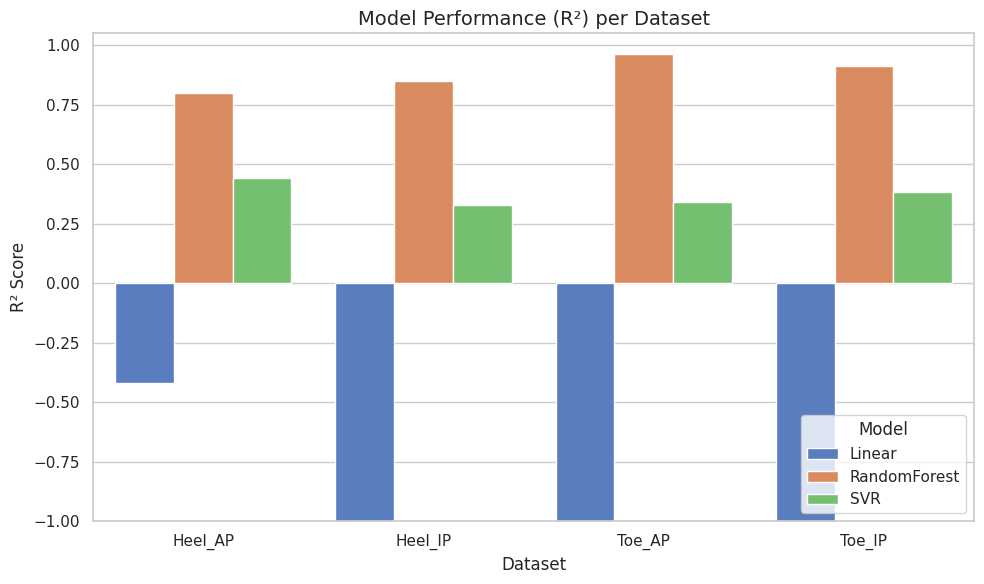

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(10, 6))

# Barplot: R2 by Dataset and Model
sns.barplot(
    data=results_df,
    x="Dataset",
    y="R2",
    hue="Model",
    palette="muted"
)

# Titles and labels
plt.title("Model Performance (R²) per Dataset", fontsize=14)
plt.ylabel("R² Score")
plt.ylim(-1, 1.05)  # Adjust based on your results
plt.legend(title="Model", loc="lower right")
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error,
    median_absolute_error, explained_variance_score
)
import numpy as np

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "R2": r2_score(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MedAE": median_absolute_error(y_true, y_pred),
        "ExplainedVar": explained_variance_score(y_true, y_pred),
        "MAPE": np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }


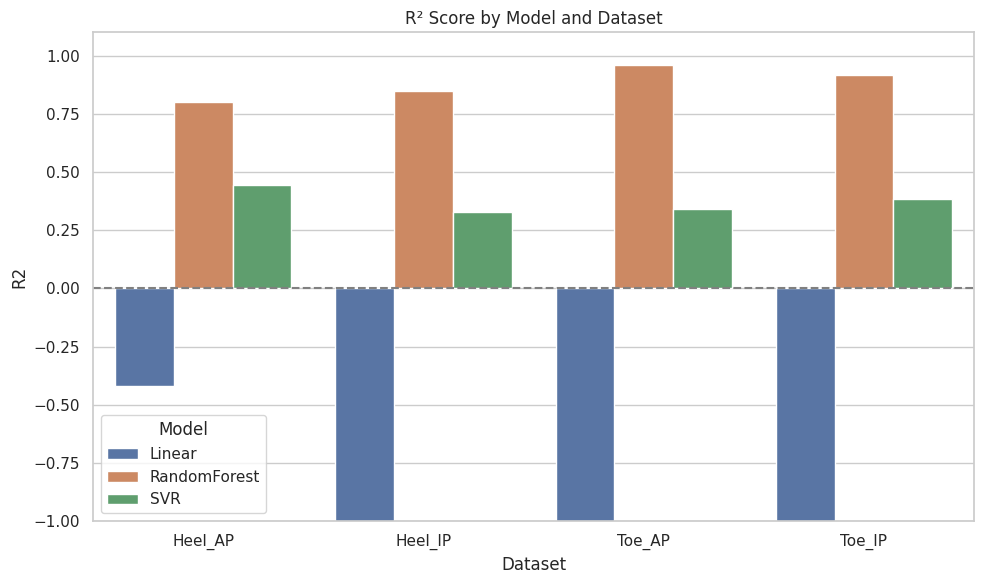

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Dataset', y='R2', hue='Model')
plt.title('R² Score by Model and Dataset')
plt.ylim(-1, 1.1)
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


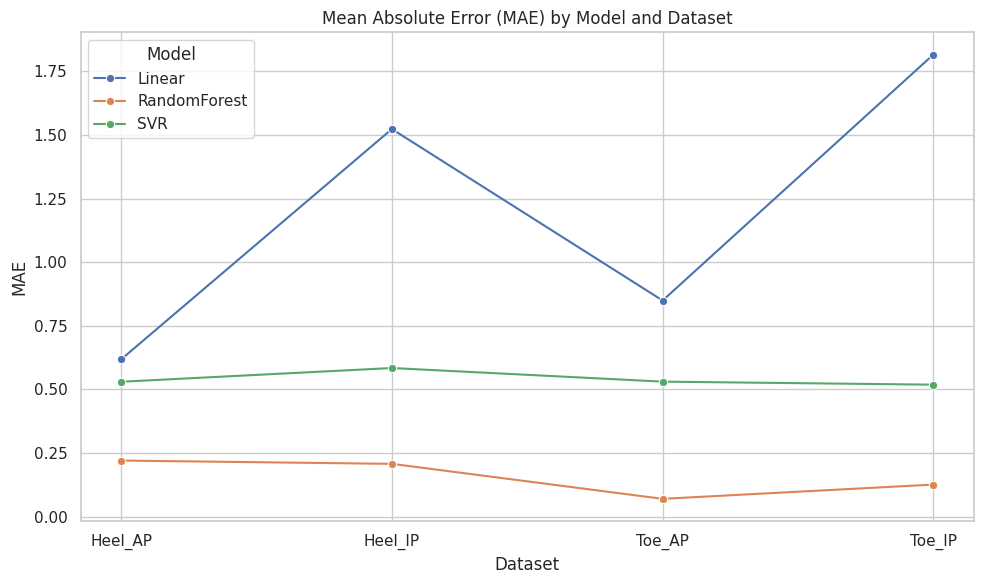

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Dataset', y='MAE', hue='Model', marker='o')
plt.title('Mean Absolute Error (MAE) by Model and Dataset')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()


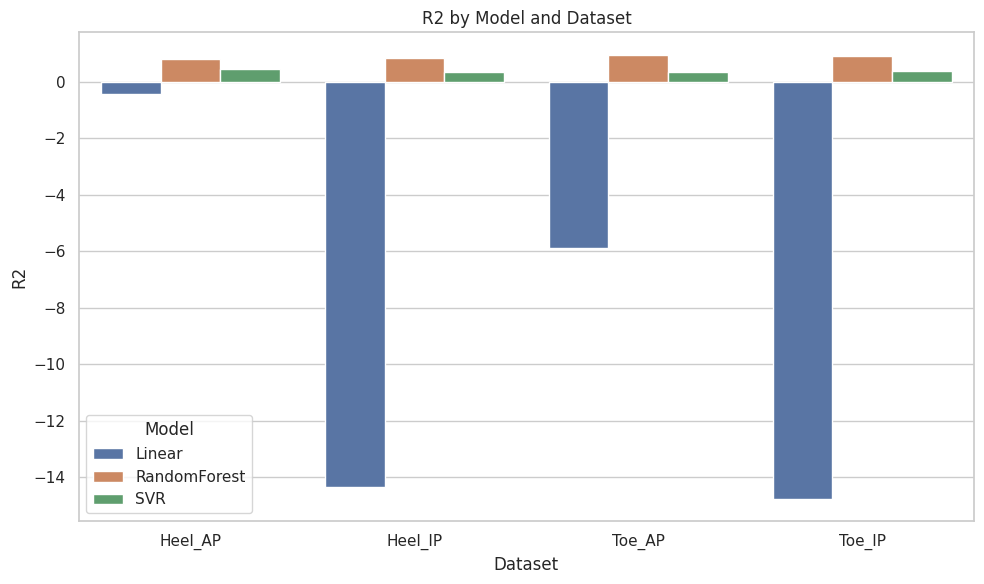

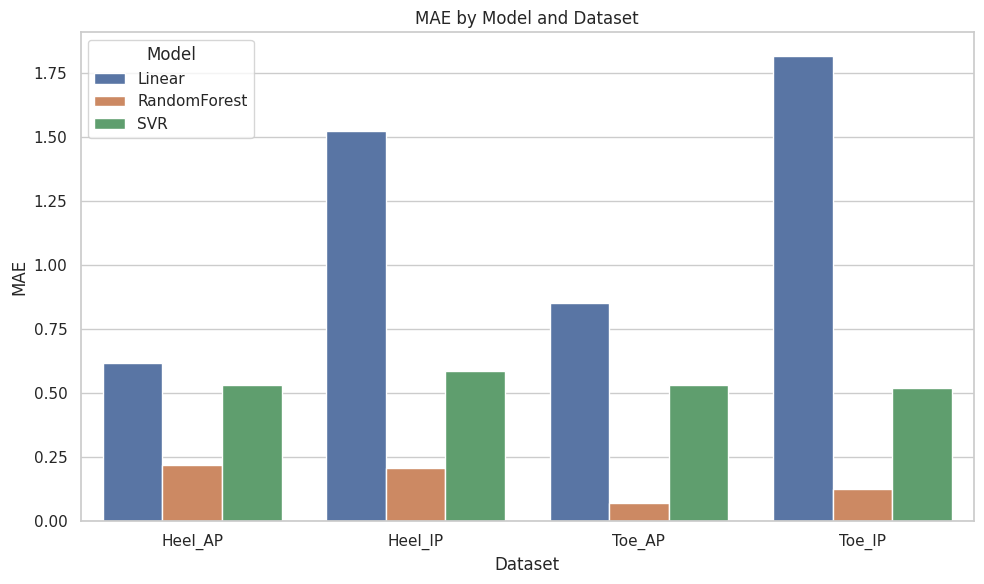

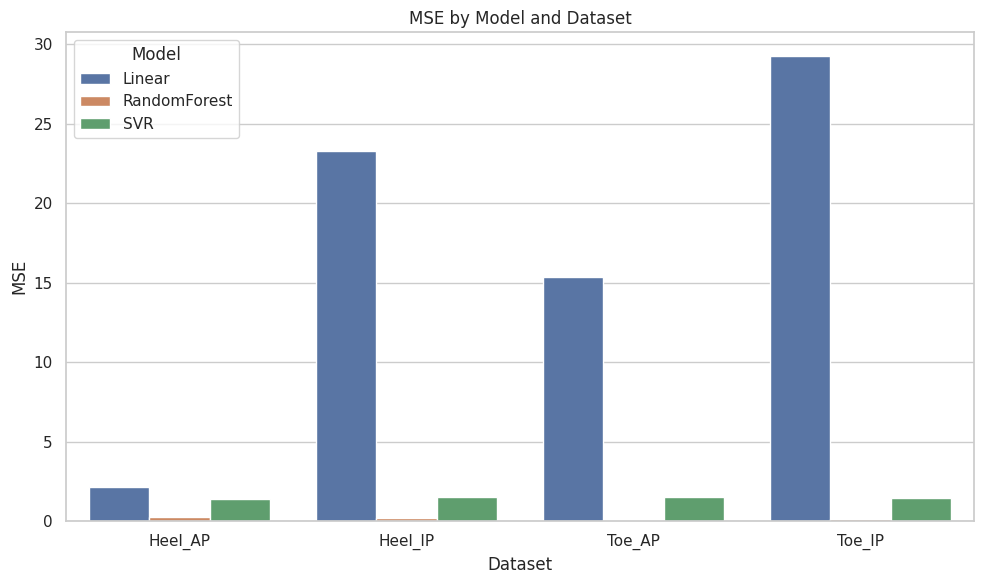

In [ ]:
metrics_to_plot = ['R2', 'MAE', 'MSE']
for metric in metrics_to_plot:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=results_df, x='Dataset', y=metric, hue='Model')
    plt.title(f'{metric} by Model and Dataset')
    plt.tight_layout()
    plt.show()


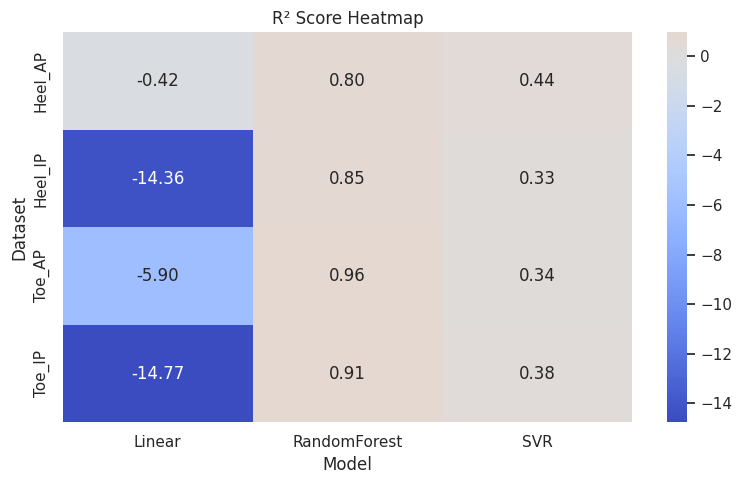

In [ ]:
pivot_r2 = results_df.pivot(index='Dataset', columns='Model', values='R2')
plt.figure(figsize=(8, 5))
sns.heatmap(pivot_r2, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('R² Score Heatmap')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
import pandas as pd
import numpy as np

# Target domains from MoCA
moca_domains = ['Visuospatial', 'Naming', 'Attention', 'Language', 'Abstraction', 'Delayed Recall', 'Orientation']

# Models to evaluate
models = {
    'Linear': LinearRegression(),
    'RandomForest': RandomForestRegressor(random_state=42, n_estimators=1000),
    'SVR': SVR()
}

# Store results
domain_results = []

# Run evaluations
for domain in moca_domains:
    for dataset_name, parts in dataset_inputs.items():
        X = parts['X']
        y_df = parts['y_df']
        subject_ids = parts['subject_ids']

        # Align targets
        y = pd.merge(pd.DataFrame({'subject': subject_ids}), y_df[['subject', domain]], on='subject', how='left')[domain].values

        for model_name, model in models.items():
            preds = []
            trues = []
            groups = subject_ids

            logo = LeaveOneGroupOut()
            for train_idx, test_idx in logo.split(X, y, groups=groups):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                preds.extend(y_pred)
                trues.extend(y_test)

            domain_results.append({
                'Domain': domain,
                'Dataset': dataset_name,
                'Model': model_name,
                'R2': r2_score(trues, preds),
                'MSE': mean_squared_error(trues, preds),
                'MAE': mean_absolute_error(trues, preds)
            })

# Create result DataFrame
domain_results_df = pd.DataFrame(domain_results)
domain_results_df = domain_results_df.sort_values(by=["Domain", "Dataset", "Model"]).reset_index(drop=True)


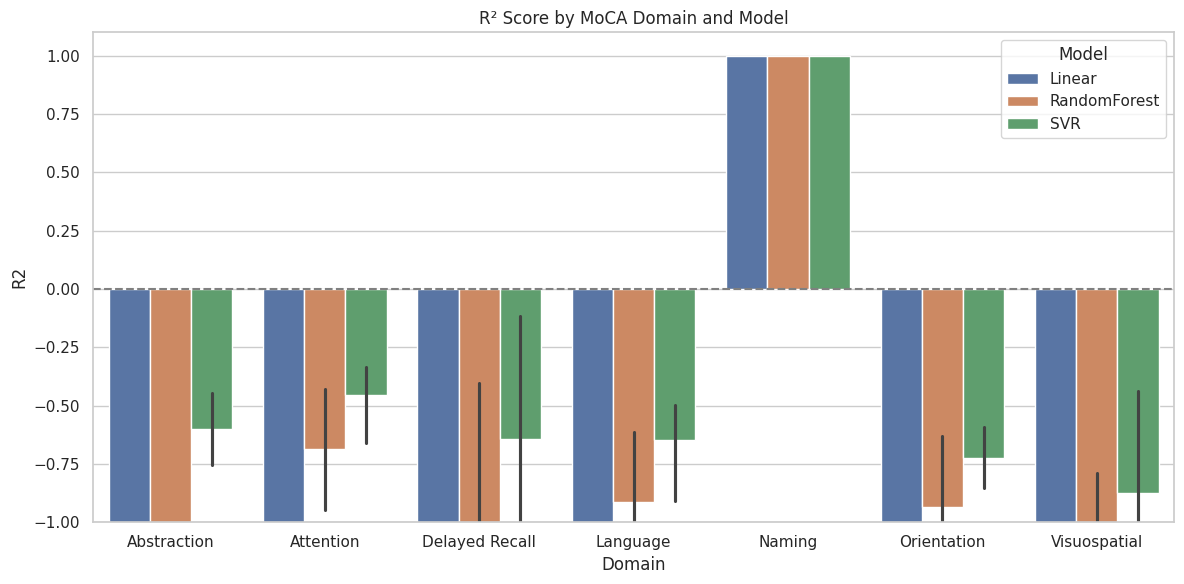

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: R2 plot per domain
plt.figure(figsize=(12, 6))
sns.barplot(data=domain_results_df, x='Domain', y='R2', hue='Model')
plt.title('R² Score by MoCA Domain and Model')
plt.ylim(-1, 1.1)
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


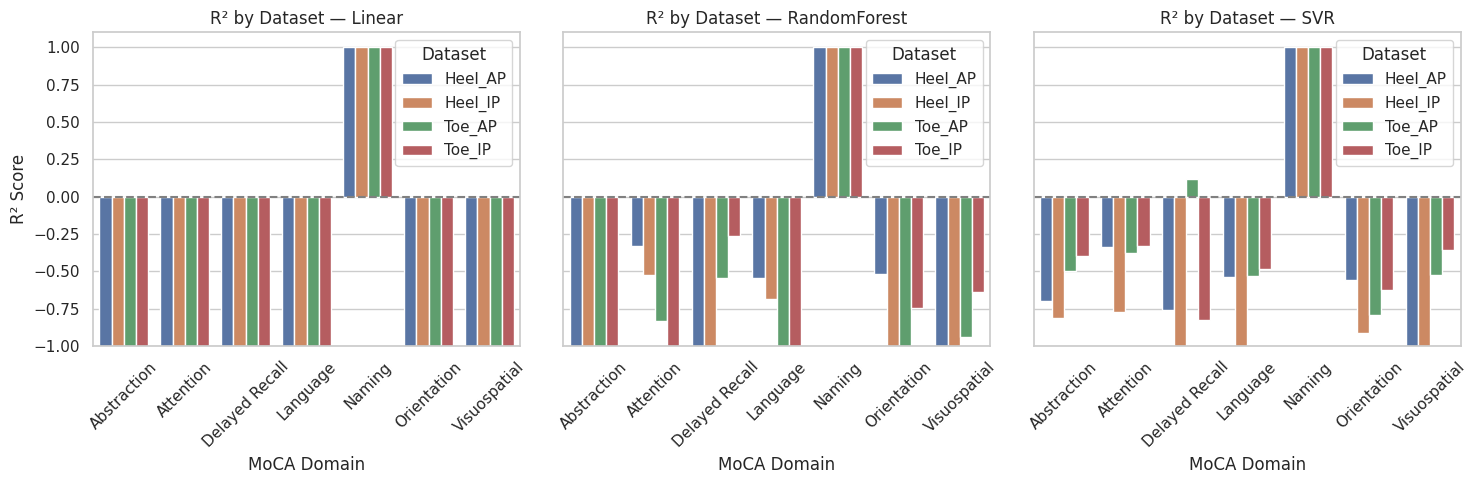

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Unique models
model_list = domain_results_df['Model'].unique()
num_models = len(model_list)

# Plot setup
fig, axes = plt.subplots(nrows=1, ncols=num_models, figsize=(5 * num_models, 5), sharey=True)

for idx, model in enumerate(model_list):
    ax = axes[idx]
    data = domain_results_df[domain_results_df['Model'] == model]
    sns.barplot(data=data, x='Domain', y='R2', hue='Dataset', ax=ax)
    ax.set_title(f'R² by Dataset — {model}')
    ax.set_ylabel('R² Score')
    ax.set_xlabel('MoCA Domain')
    ax.axhline(0, color='gray', linestyle='--')
    ax.set_ylim(-1, 1.1)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


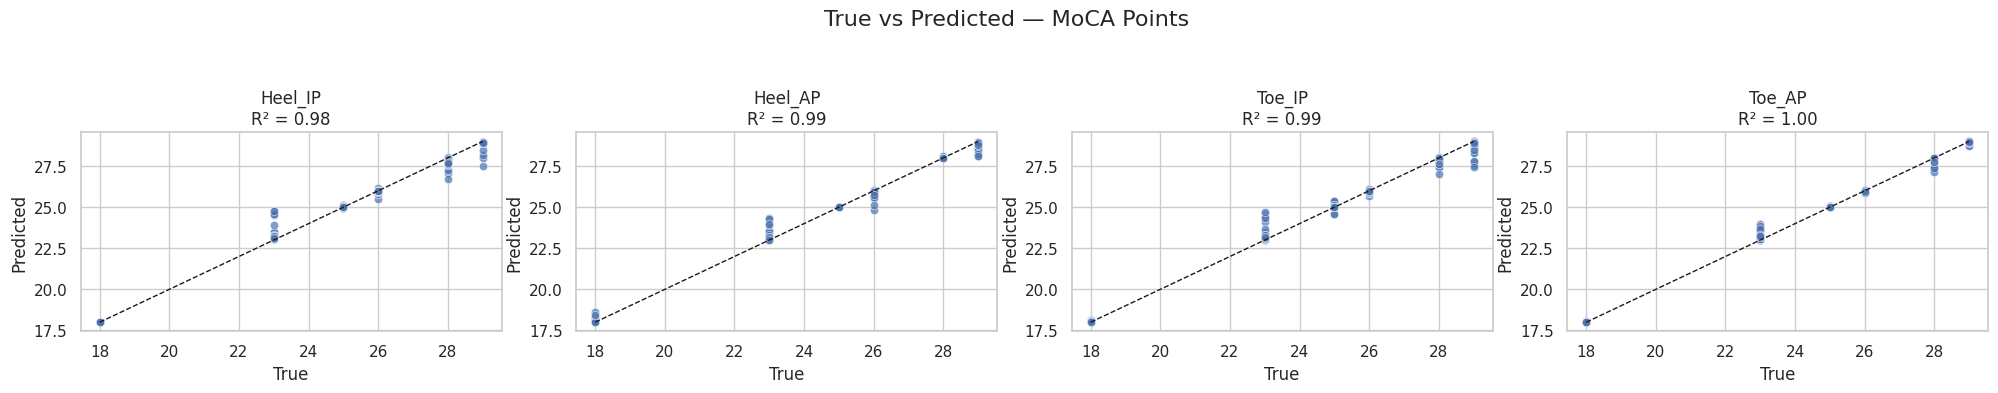

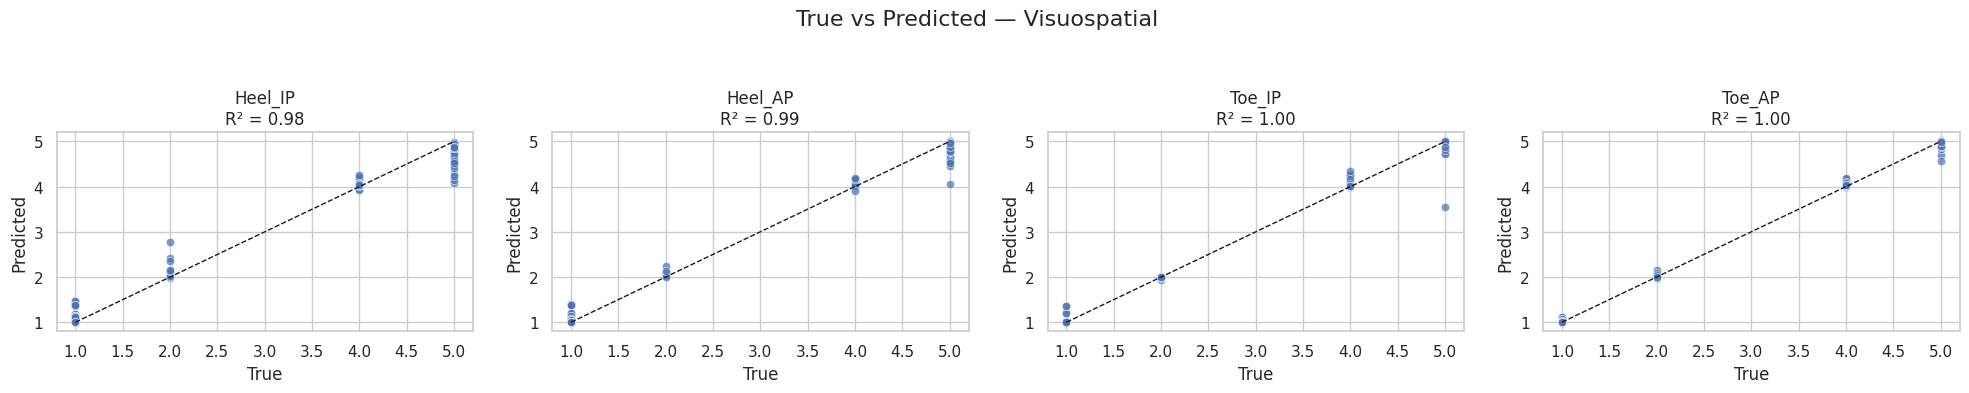

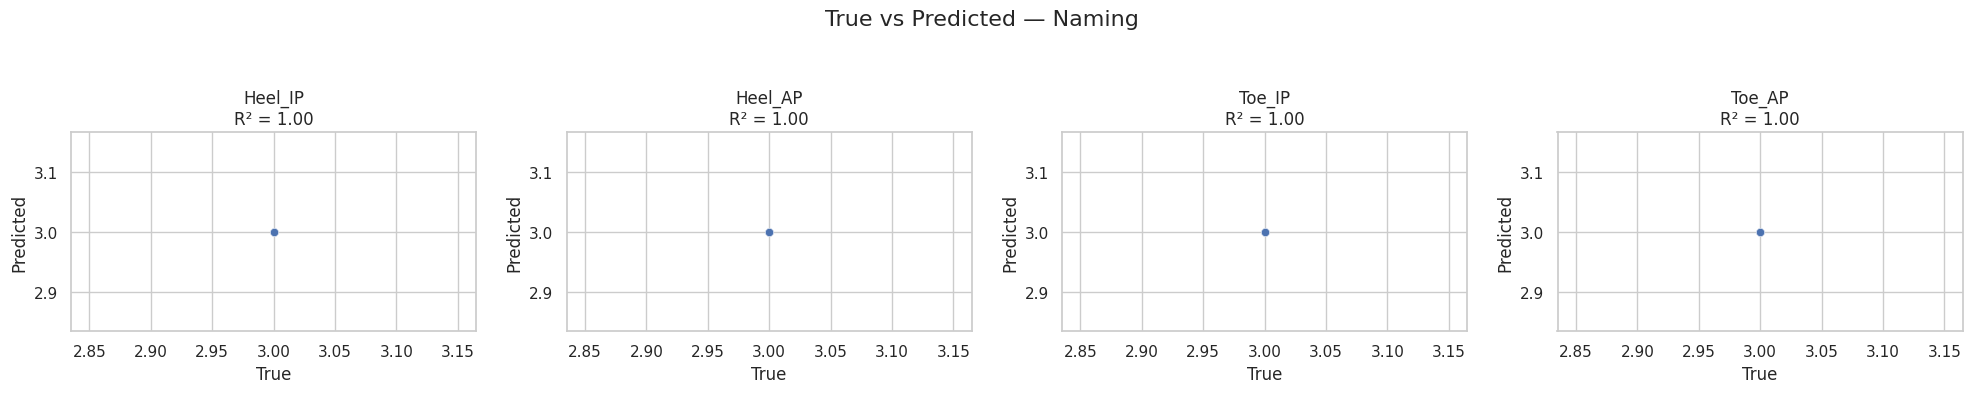

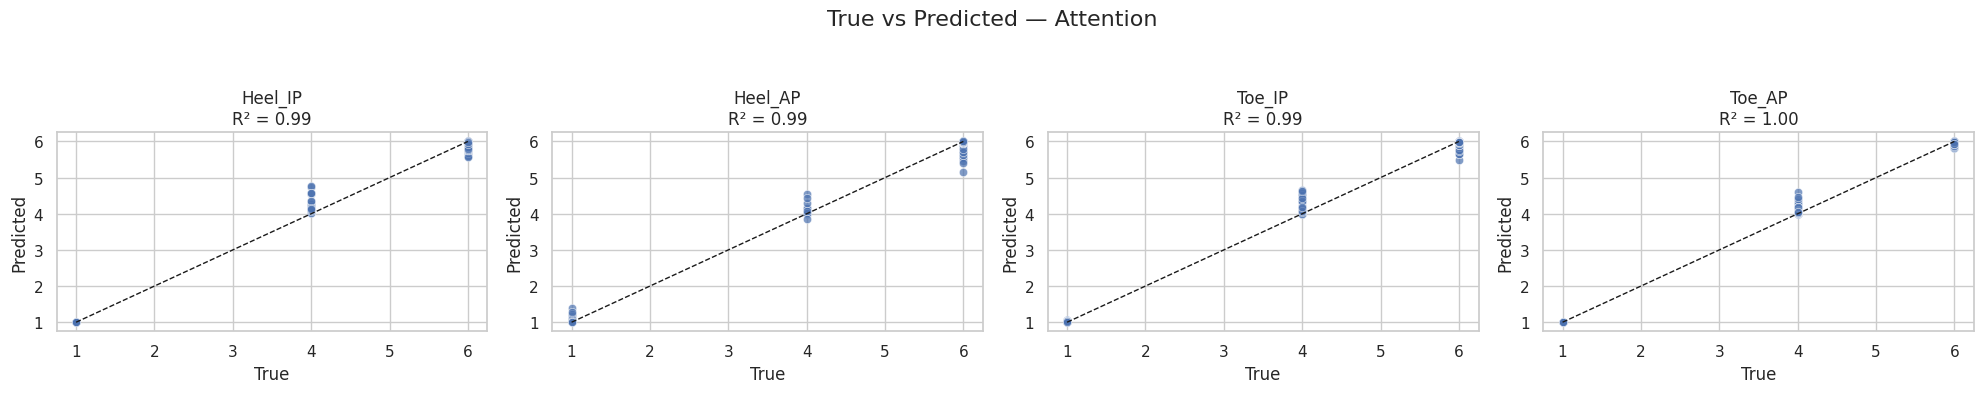

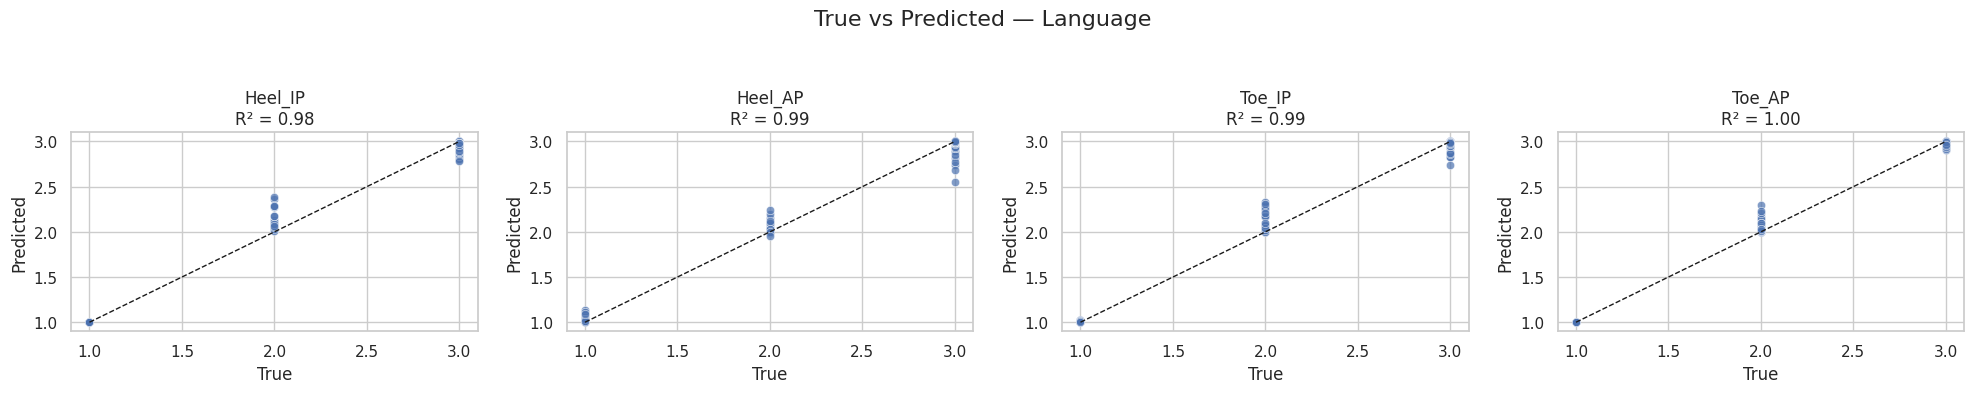

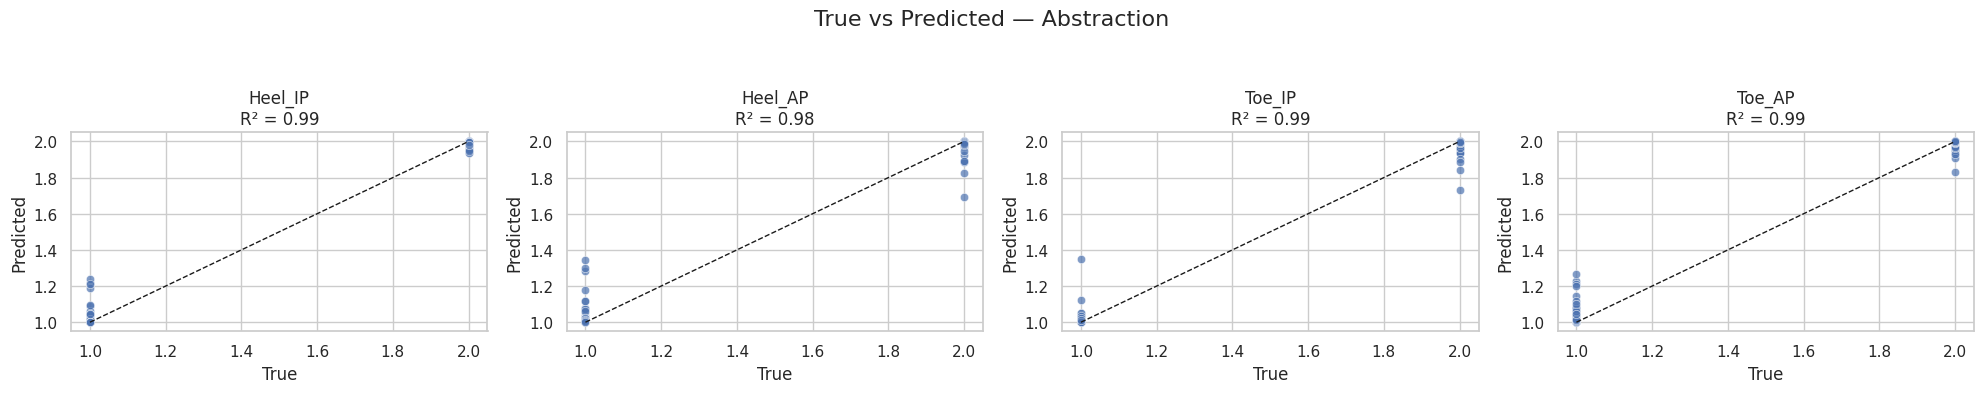

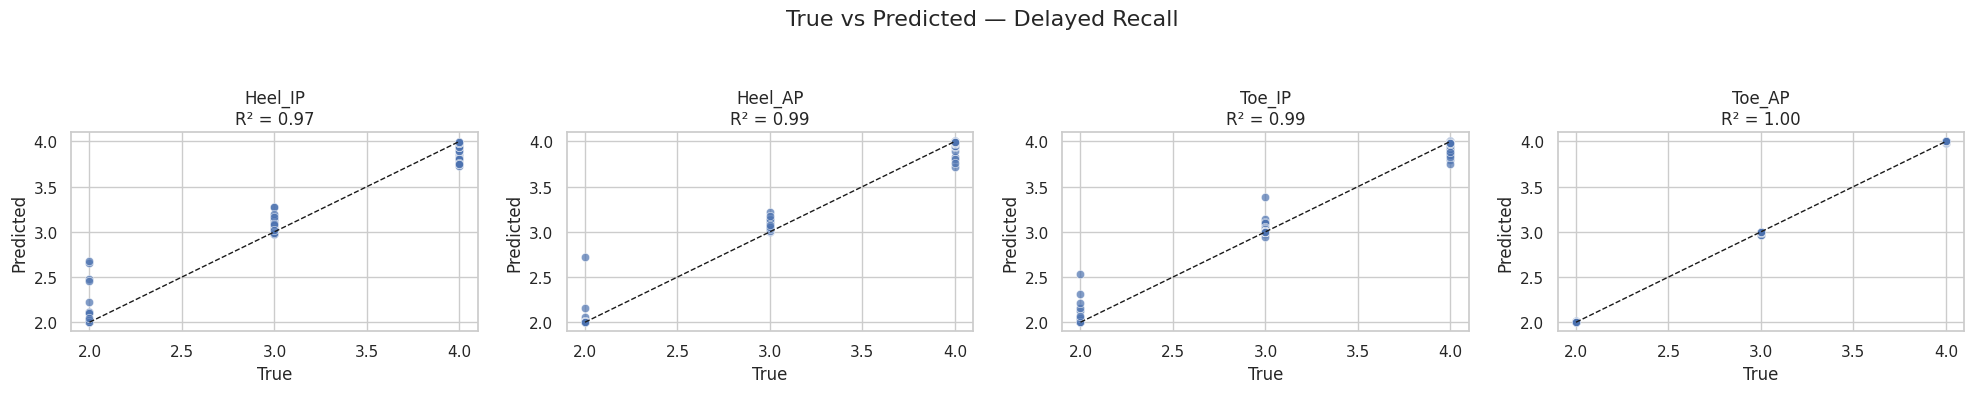

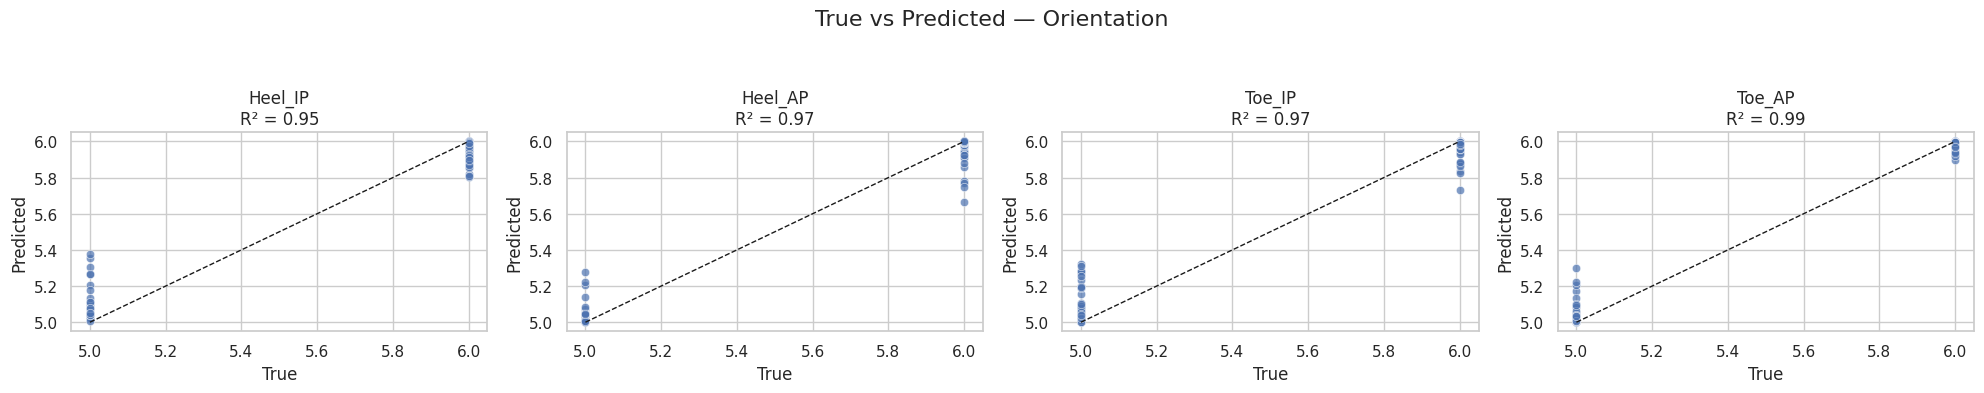

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# List all domains
moca_domains = [
    'MoCA Points', 'Visuospatial', 'Naming', 'Attention',
    'Language', 'Abstraction', 'Delayed Recall', 'Orientation'
]

# Choose model type
model_type = "RandomForest"

# Loop through each domain
for domain in moca_domains:
    plt.figure(figsize=(20, 4))

    for i, (dataset_name, data) in enumerate(dataset_inputs.items()):
        X = data["X"]
        y_df = data["y_df"]
        subject_ids = data["subject_ids"]

        # Match subject rows to domain scores
        y_true_all = []
        for sid in subject_ids:
            val = y_df[y_df["subject"] == sid][domain]
            y_true_all.append(val.values[0] if not val.empty else np.nan)
        y_true_all = np.array(y_true_all)

        # Clean NaNs
        mask = ~np.isnan(y_true_all)
        X_valid = X.iloc[mask]
        y_valid = y_true_all[mask]

        # Fit model
        model = RandomForestRegressor(random_state=42, n_estimators=1000)
        model.fit(X_valid, y_valid)
        y_pred = model.predict(X_valid)

        # Plot
        plt.subplot(1, 4, i + 1)
        sns.scatterplot(x=y_valid, y=y_pred, alpha=0.7)
        plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'k--', lw=1)
        plt.title(f"{dataset_name}\nR² = {r2_score(y_valid, y_pred):.2f}")
        plt.xlabel("True")
        plt.ylabel("Predicted")
        plt.grid(True)

    plt.suptitle(f"True vs Predicted — {domain}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()


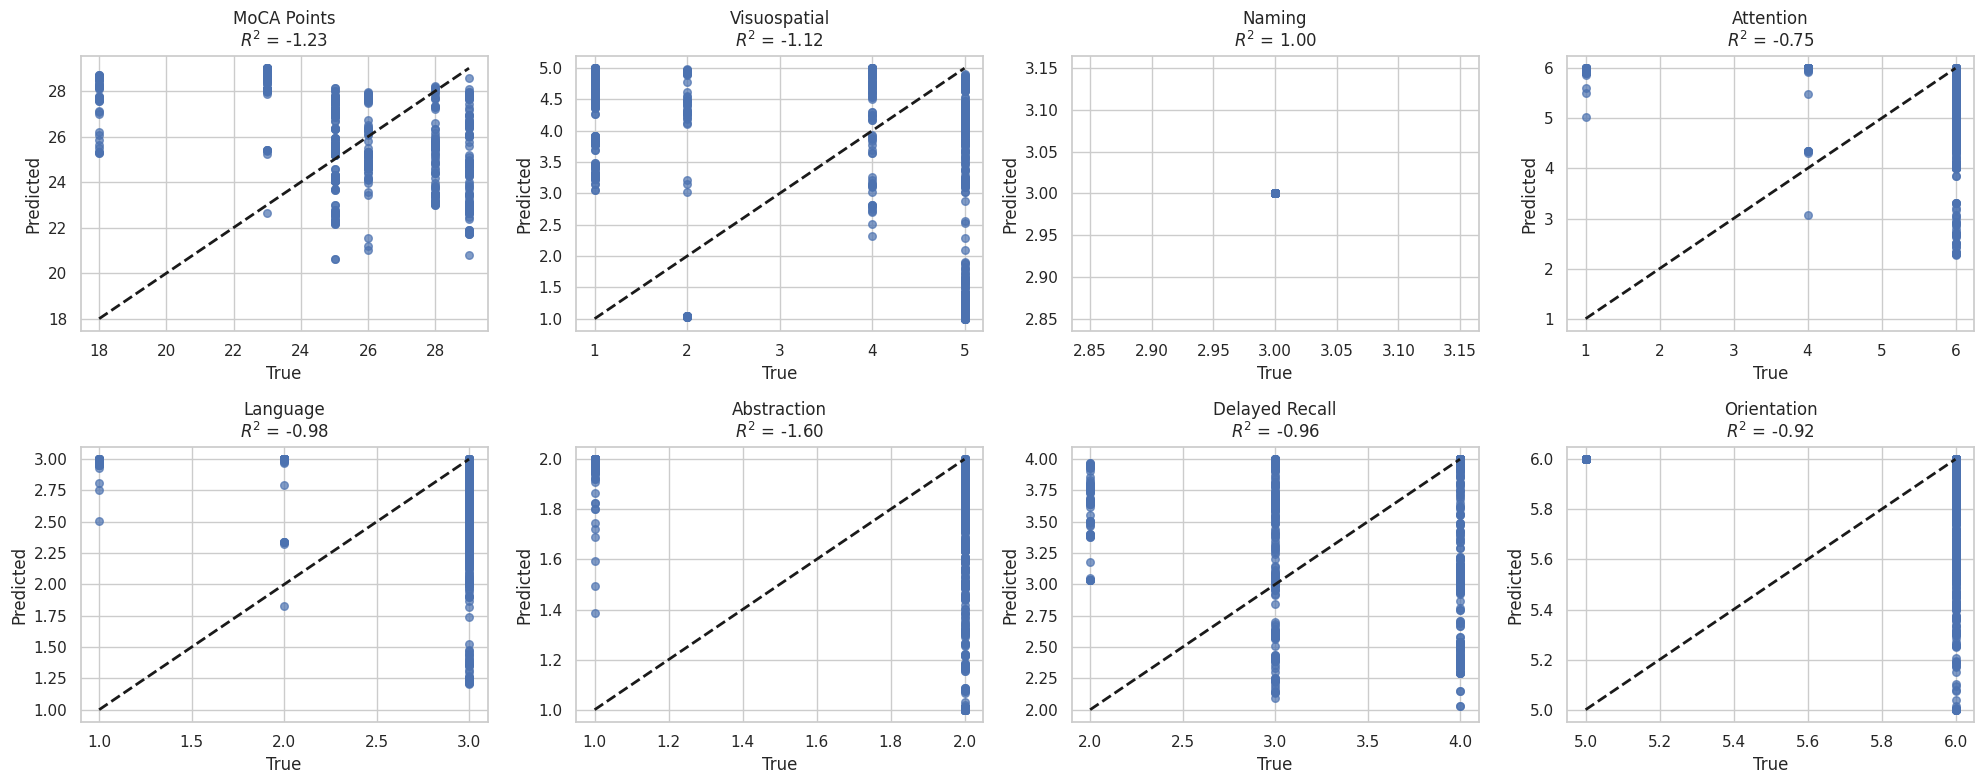

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Select MoCA targets
moca_targets = [
    'MoCA Points', 'Visuospatial', 'Naming', 'Attention',
    'Language', 'Abstraction', 'Delayed Recall', 'Orientation'
]

# For clean plotting
sns.set(style="whitegrid", font_scale=1.0)

# Helper: run LOSO for one target
def loso_predict(X, y_df, subject_ids, target_name):
    logo = LeaveOneGroupOut()
    y_true_all, y_pred_all = [], []

    y_subject_map = dict(zip(y_df['subject'], y_df[target_name]))

    for train_idx, test_idx in logo.split(X, groups=subject_ids):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        subjects_test = subject_ids[test_idx]

        # Match target values for test subjects
        y_train = [y_subject_map[subj] for subj in subject_ids[train_idx]]
        y_test = [y_subject_map[subj] for subj in subjects_test]

        model = RandomForestRegressor(n_estimators=1000, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred)

    return np.array(y_true_all), np.array(y_pred_all)

# Plotting all domains
fig, axs = plt.subplots(2, 4, figsize=(20, 8))
axs = axs.flatten()

for i, target in enumerate(moca_targets):
    ax = axs[i]

    all_true, all_pred = [], []

    # Combine predictions from all datasets
    for name, data in dataset_inputs.items():
        X = data["X"]
        y_df = data["y_df"]
        subject_ids = data["subject_ids"]

        y_true, y_pred = loso_predict(X, y_df, subject_ids, target)
        all_true.extend(y_true)
        all_pred.extend(y_pred)

    r2 = r2_score(all_true, all_pred)
    ax.scatter(all_true, all_pred, s=30, alpha=0.7)
    ax.plot([min(all_true), max(all_true)], [min(all_true), max(all_true)], 'k--', lw=2)
    ax.set_title(f"{target}\n$R^2$ = {r2:.2f}")
    ax.set_xlabel("True")
    ax.set_ylabel("Predicted")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import r2_score
import numpy as np

def run_loso_predictions(dataset_inputs, moca_targets):
    results = {target: {"true": [], "pred": [], "dataset": []} for target in moca_targets}

    for dataset_name, data in dataset_inputs.items():
        X = data["X"]
        y_df = data["y_df"]
        subject_ids = data["subject_ids"]
        logo = LeaveOneGroupOut()

        for target in moca_targets:
            y_subject_map = dict(zip(y_df['subject'], y_df[target]))
            y_true_all, y_pred_all = [], []

            for train_idx, test_idx in logo.split(X, groups=subject_ids):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                subjects_train = subject_ids[train_idx]
                subjects_test = subject_ids[test_idx]

                y_train = [y_subject_map[subj] for subj in subjects_train]
                y_test = [y_subject_map[subj] for subj in subjects_test]

                model = RandomForestRegressor(n_estimators=100, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                y_true_all.extend(y_test)
                y_pred_all.extend(y_pred)

            results[target]["true"].extend(y_true_all)
            results[target]["pred"].extend(y_pred_all)
            results[target]["dataset"].extend([dataset_name] * len(y_true_all))

    return results


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_loso_predictions(results):
    num_targets = len(results)
    fig, axs = plt.subplots(2, (num_targets + 1) // 2, figsize=(22, 10))
    axs = axs.flatten()

    for i, (target, res) in enumerate(results.items()):
        true_vals = np.array(res["true"])
        pred_vals = np.array(res["pred"])
        r2 = r2_score(true_vals, pred_vals)
        axs[i].scatter(true_vals, pred_vals, alpha=0.7)
        axs[i].plot([true_vals.min(), true_vals.max()], [true_vals.min(), true_vals.max()], 'k--')
        axs[i].set_title(f"{target}\n$R^2$ = {r2:.2f}")
        axs[i].set_xlabel("True")
        axs[i].set_ylabel("Predicted")

    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


In [ ]:
results = run_loso_predictions(dataset_inputs, moca_targets)



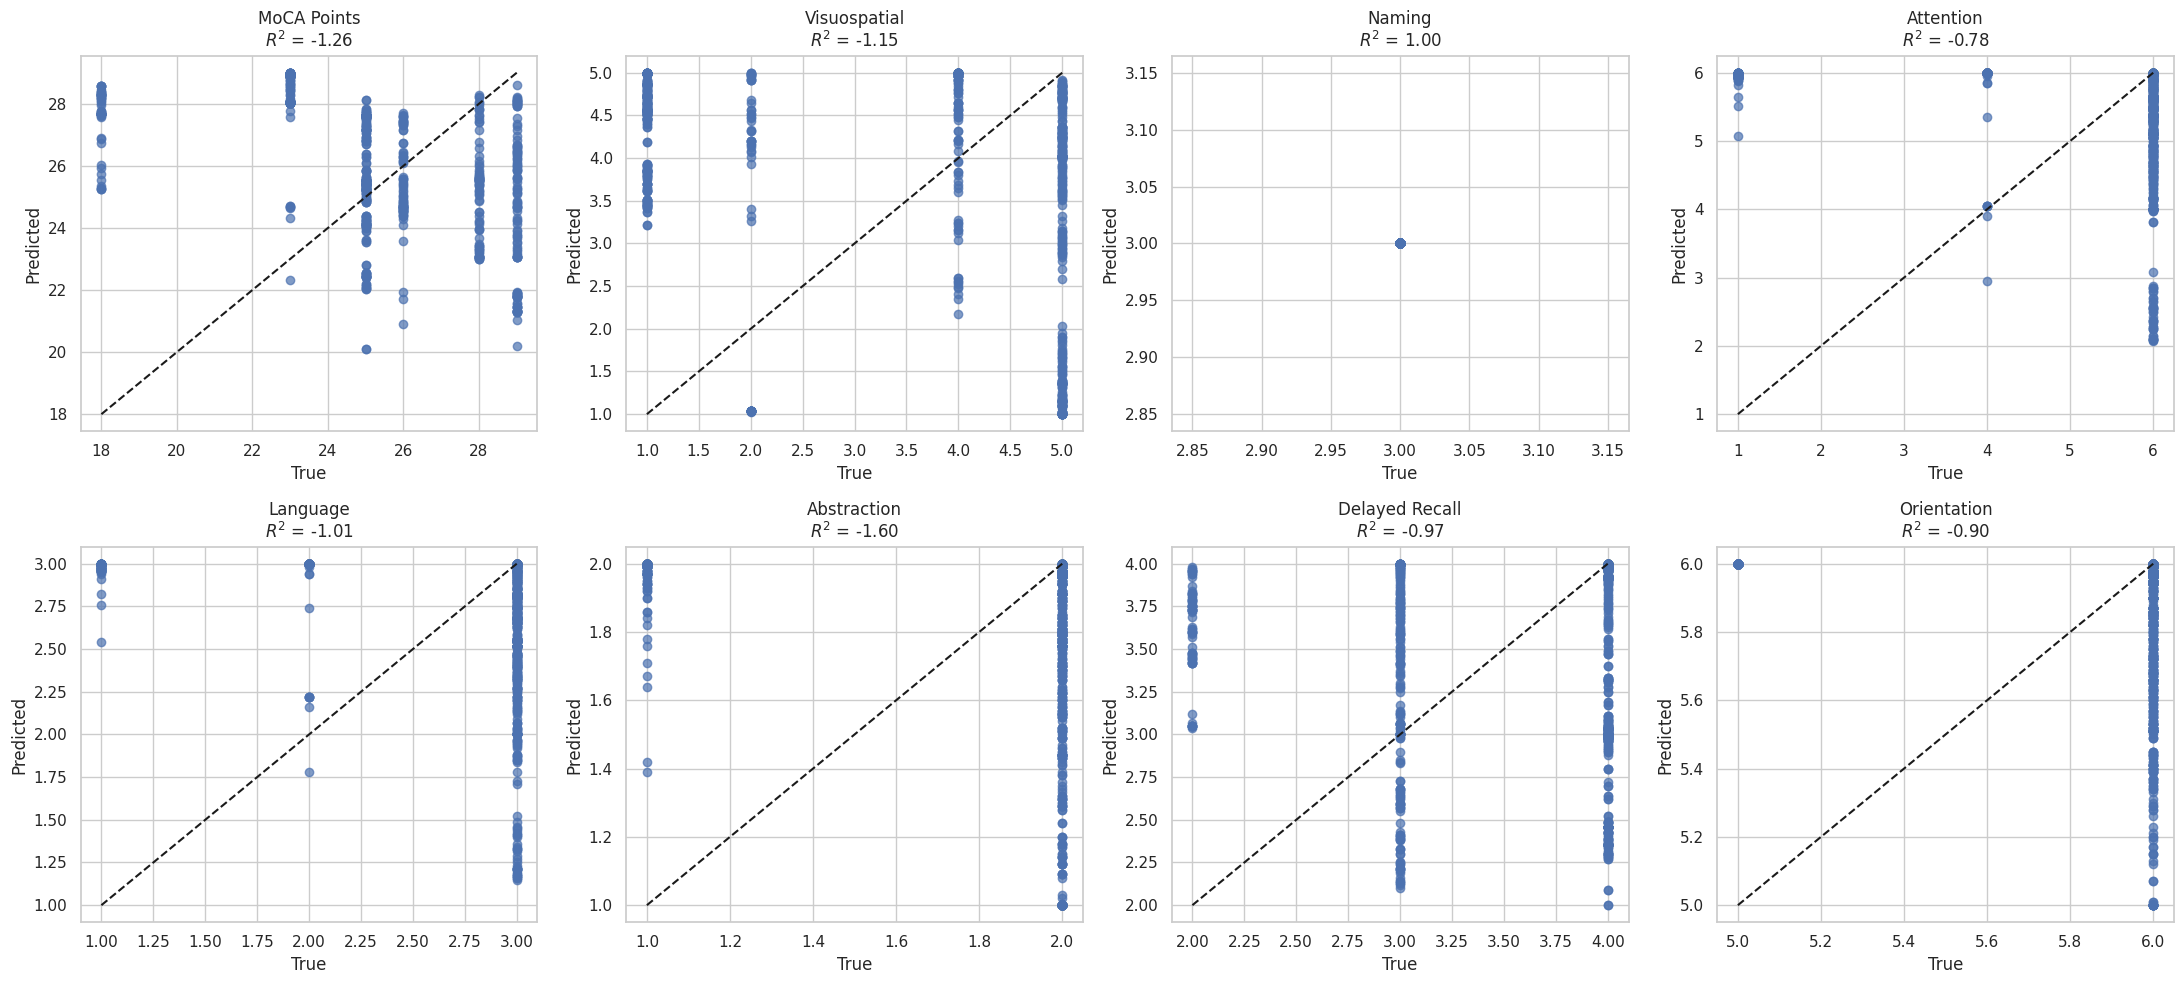

In [ ]:
plot_loso_predictions(results)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import numpy as np

def run_kfold_predictions(dataset_inputs, moca_targets, k=10):
    results = {target: {"true": [], "pred": [], "dataset": []} for target in moca_targets}

    for dataset_name, data in dataset_inputs.items():
        print(f"Running K-Fold for: {dataset_name}")
        X = data["X"]
        y_df = data["y_df"]
        subject_ids = data["subject_ids"]

        # Map subject-level targets to sample-level
        subject_target_map = y_df.set_index("subject")[moca_targets].to_dict(orient="index")
        y_all = np.array([subject_target_map[subj] for subj in subject_ids])

        for i, target in enumerate(moca_targets):
            y = np.array([vals[target] for vals in y_all])

            kf = KFold(n_splits=k, shuffle=True, random_state=42)
            y_true_all, y_pred_all = [], []

            for train_idx, test_idx in kf.split(X):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                model = RandomForestRegressor(n_estimators=100, random_state=42)
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                y_true_all.extend(y_test)
                y_pred_all.extend(y_pred)

            results[target]["true"].extend(y_true_all)
            results[target]["pred"].extend(y_pred_all)
            results[target]["dataset"].extend([dataset_name] * len(y_true_all))

    return results


In [ ]:
kfold_results = run_kfold_predictions(dataset_inputs, moca_targets, k=10)


Running K-Fold for: Heel_IP
Running K-Fold for: Heel_AP
Running K-Fold for: Toe_IP
Running K-Fold for: Toe_AP


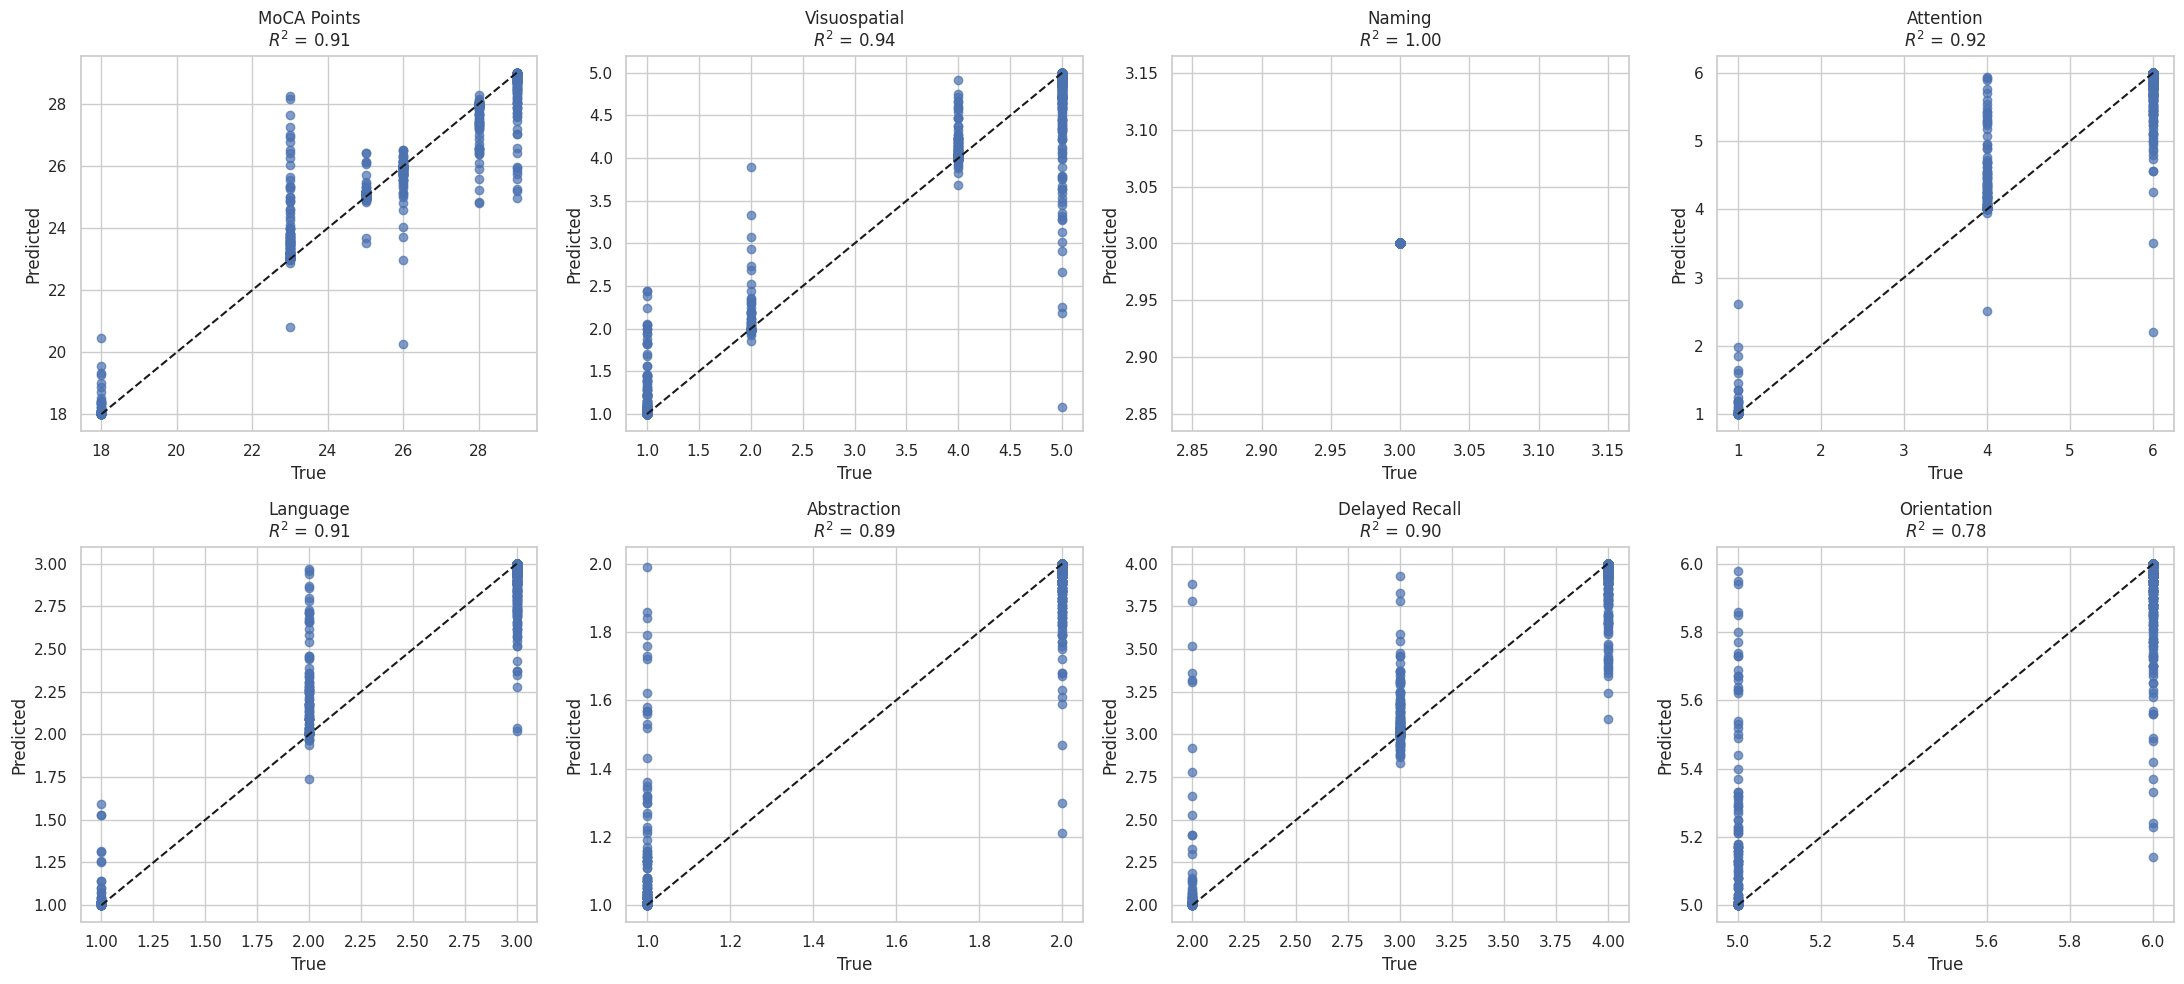

In [ ]:
plot_loso_predictions(kfold_results)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score

def plot_loso_predictions_grouped_by_dataset(kfold_results):
    for domain, results in kfold_results.items():
        # Extract data by dataset
        data_by_dataset = {}
        for true_val, pred_val, dataset in zip(results["true"], results["pred"], results["dataset"]):
            if dataset not in data_by_dataset:
                data_by_dataset[dataset] = {"true": [], "pred": []}
            data_by_dataset[dataset]["true"].append(true_val)
            data_by_dataset[dataset]["pred"].append(pred_val)

        # Plotting
        num_datasets = len(data_by_dataset)
        fig, axs = plt.subplots(1, num_datasets, figsize=(6 * num_datasets, 5), squeeze=False)
        axs = axs.flatten()

        for i, (dataset_name, vals) in enumerate(data_by_dataset.items()):
            true_vals = np.array(vals["true"])
            pred_vals = np.array(vals["pred"])
            r2 = r2_score(true_vals, pred_vals)
            axs[i].scatter(true_vals, pred_vals, alpha=0.6)
            axs[i].plot([true_vals.min(), true_vals.max()],
                        [true_vals.min(), true_vals.max()],
                        'k--', lw=1.5)
            axs[i].set_title(f"{domain} — {dataset_name}\n$R^2$ = {r2:.2f}")
            axs[i].set_xlabel("True")
            axs[i].set_ylabel("Predicted")

        plt.suptitle(f"True vs Predicted: {domain}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


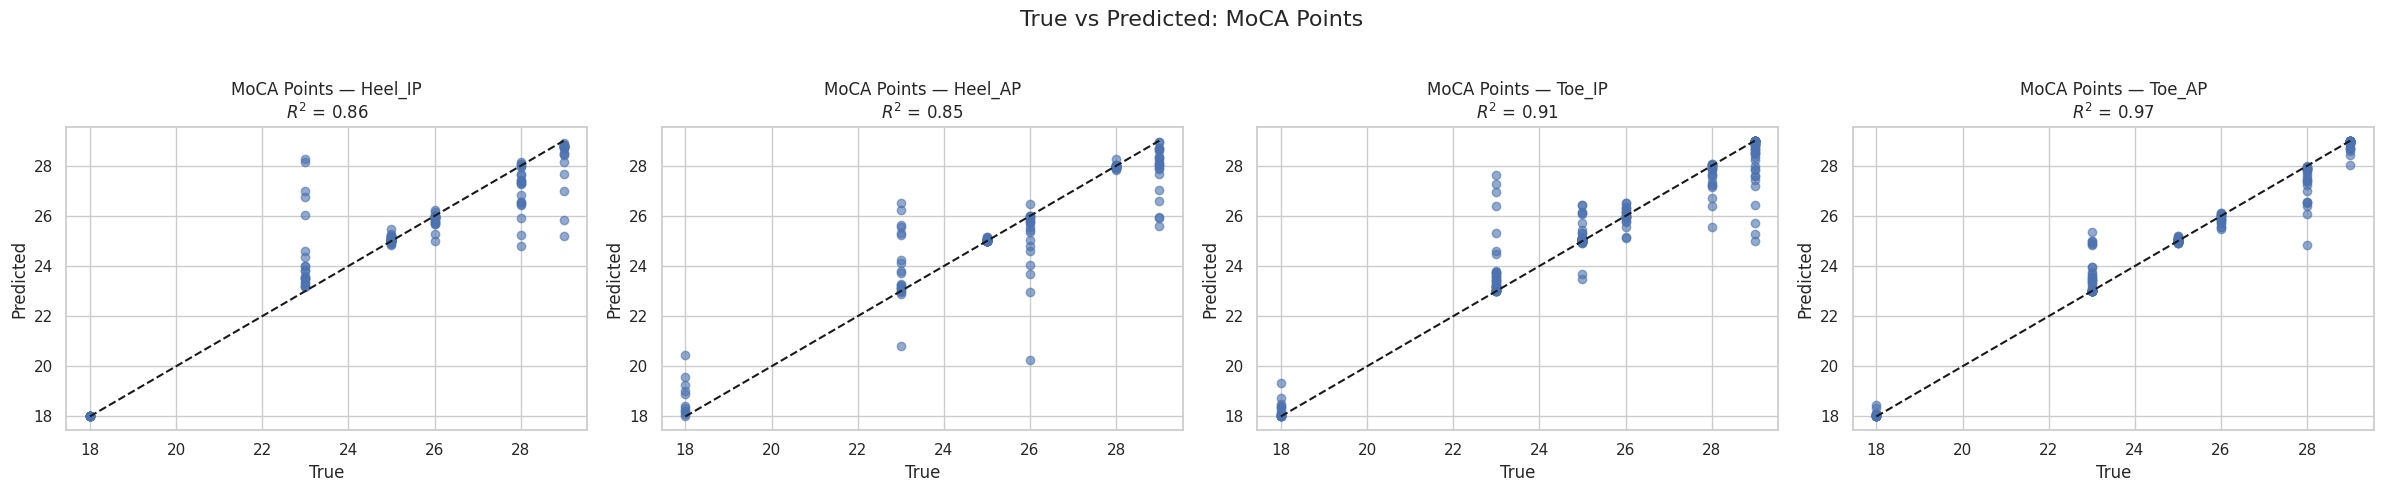

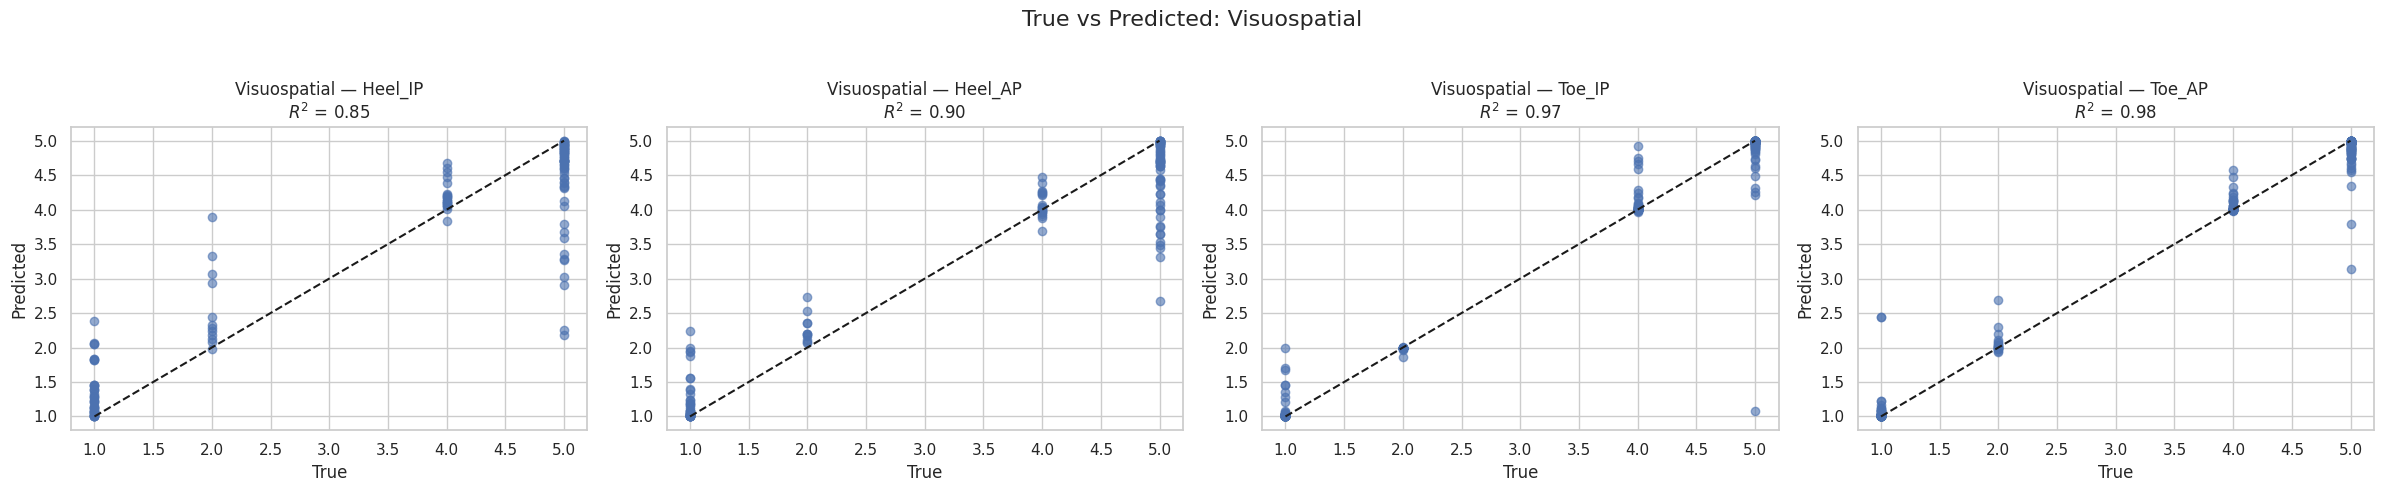

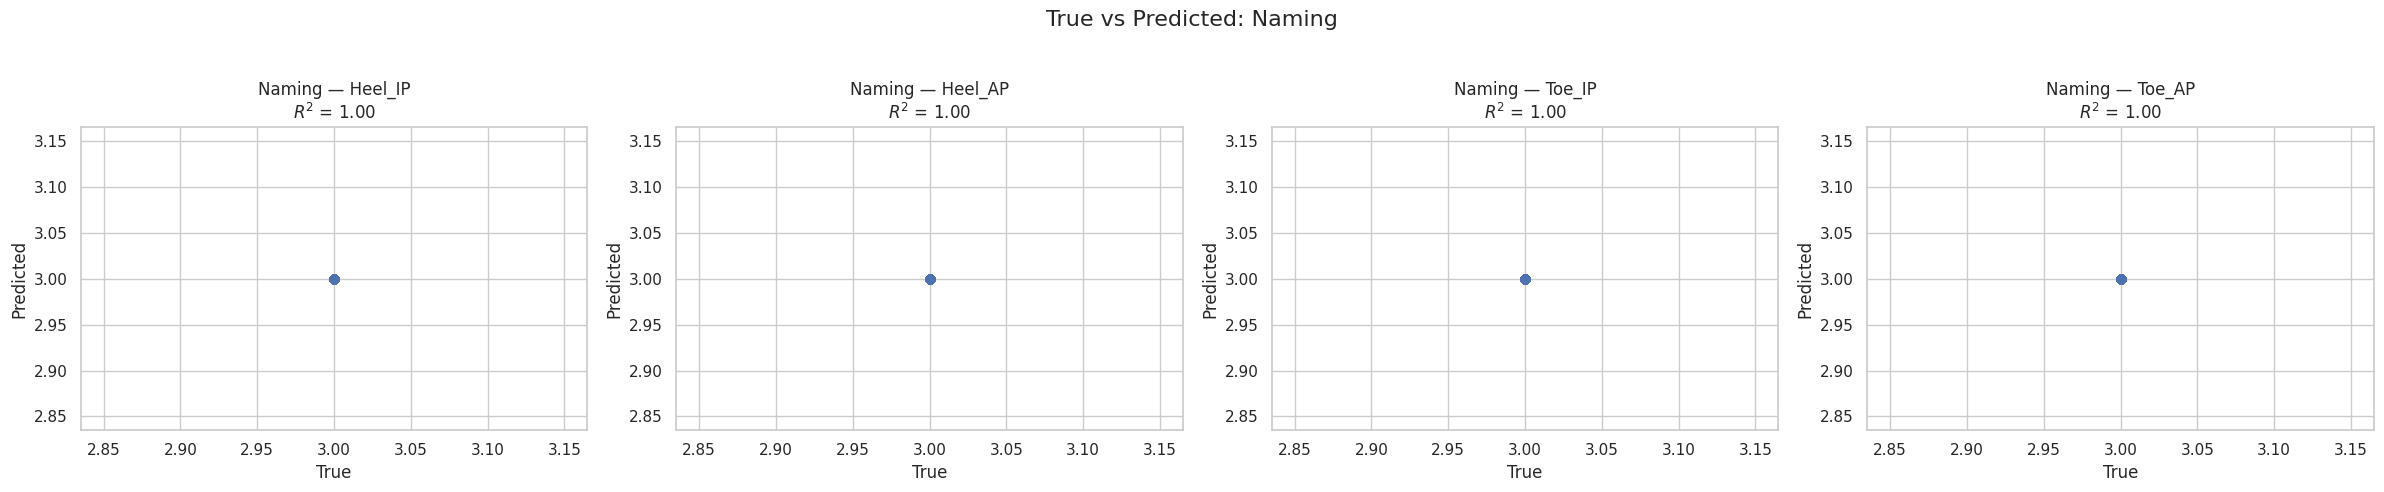

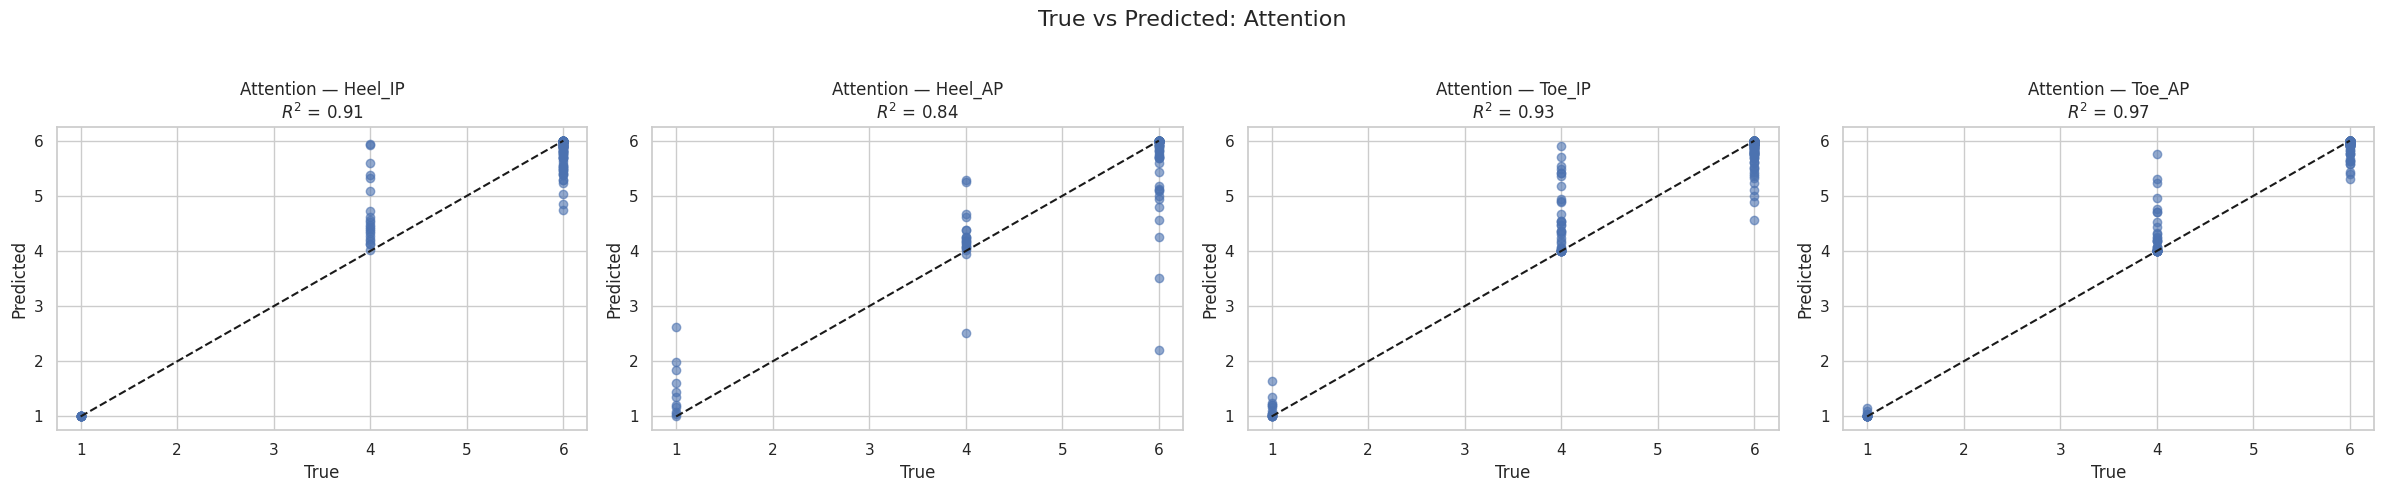

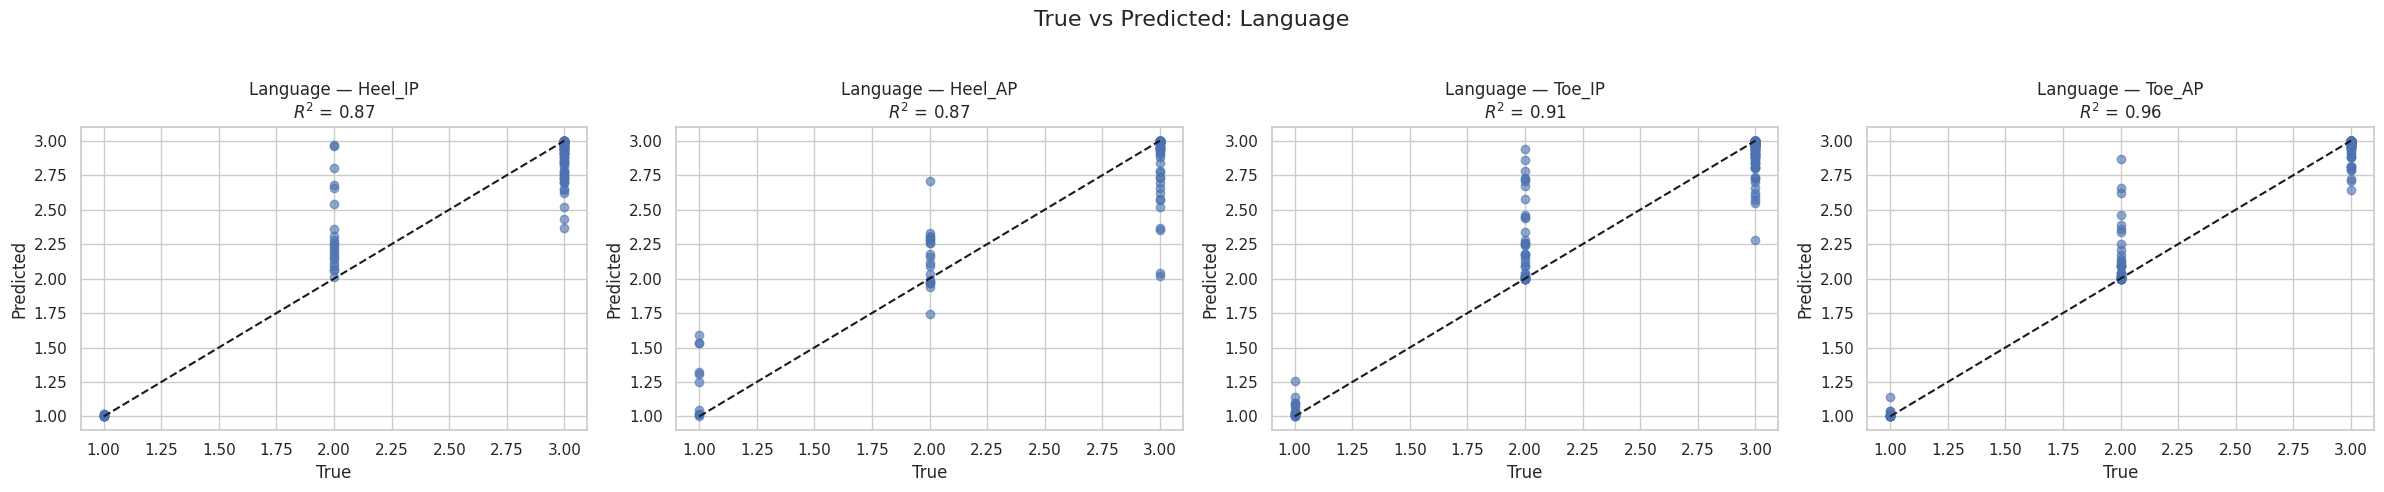

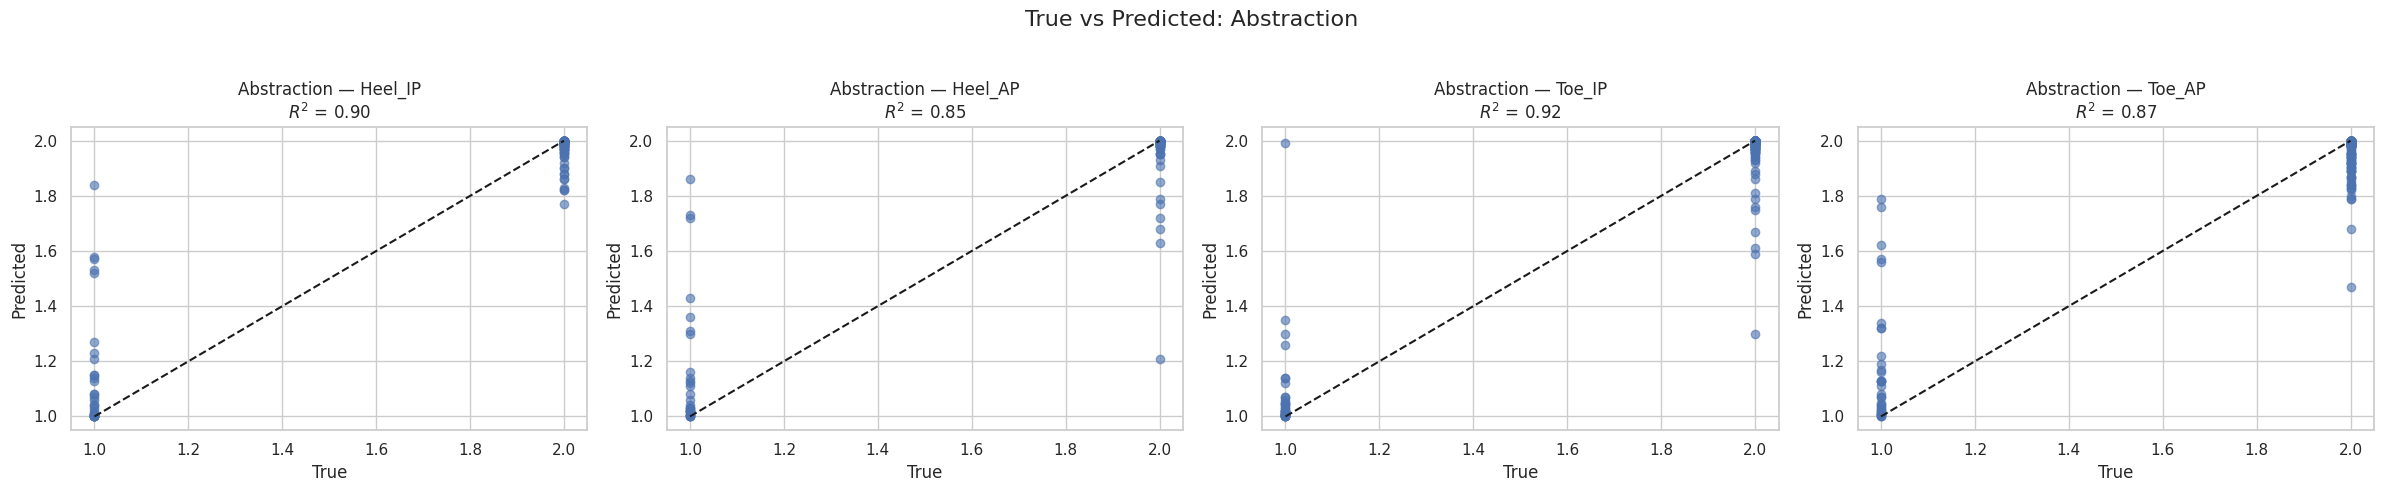

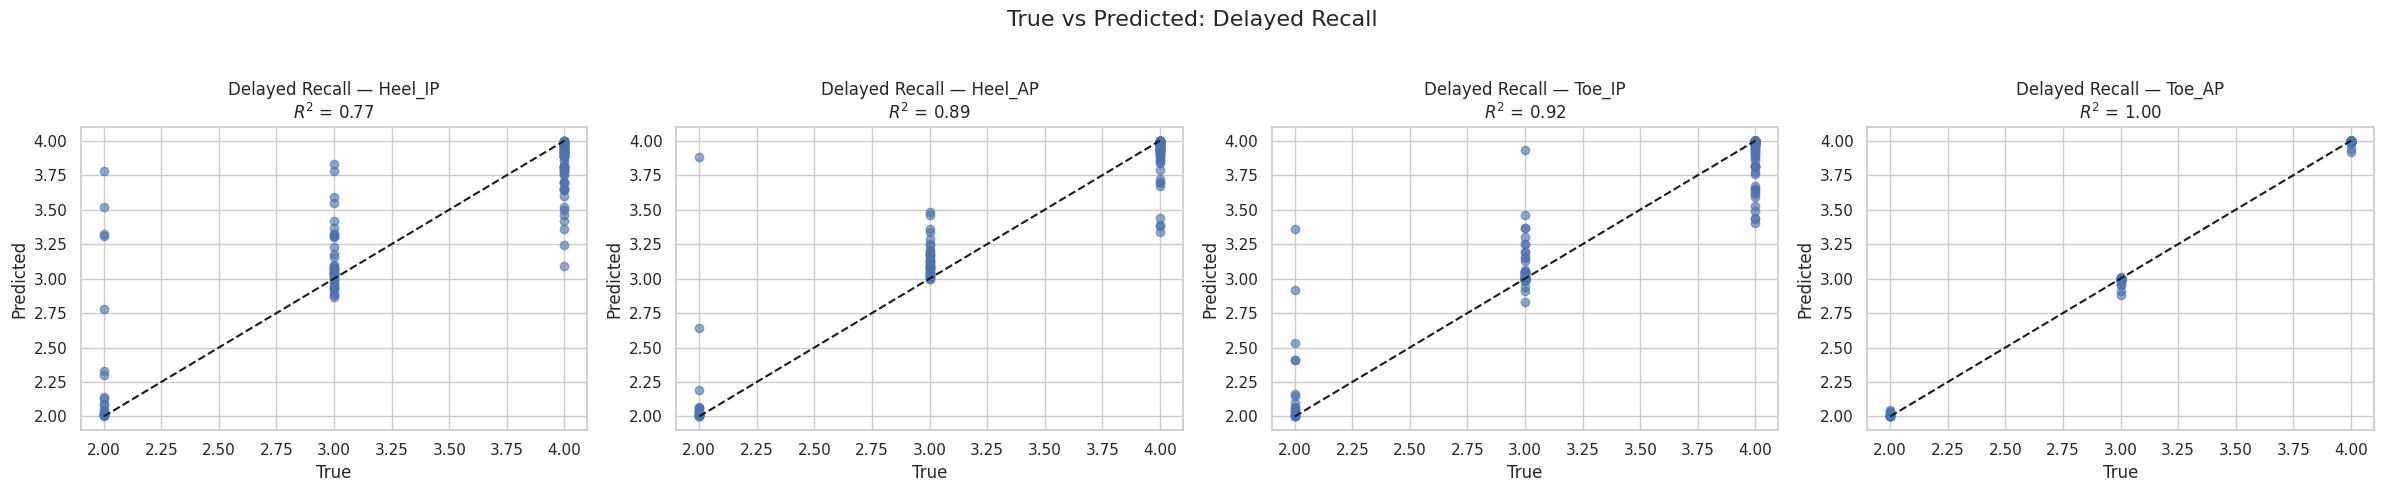

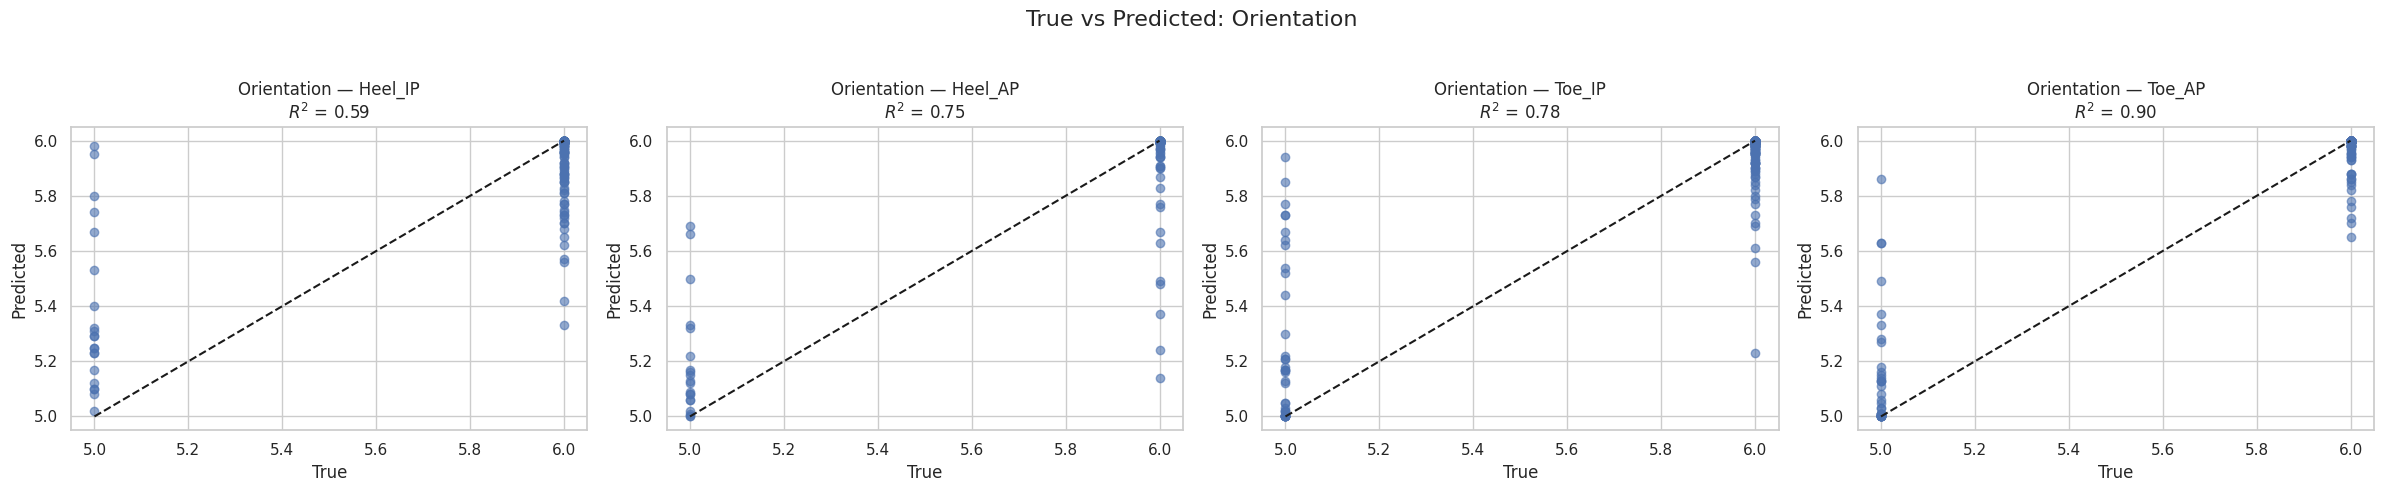

In [ ]:
plot_loso_predictions_grouped_by_dataset(kfold_results)


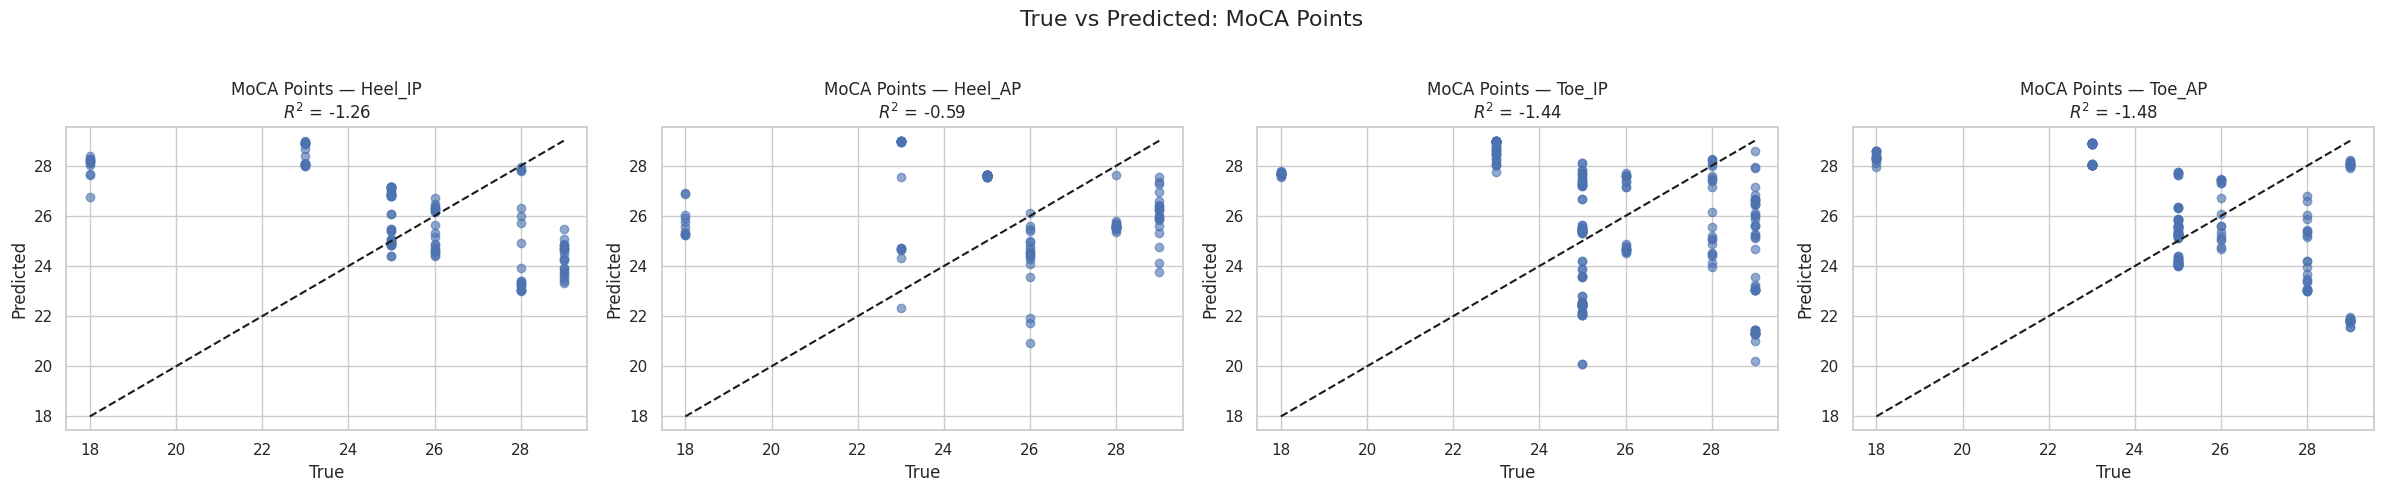

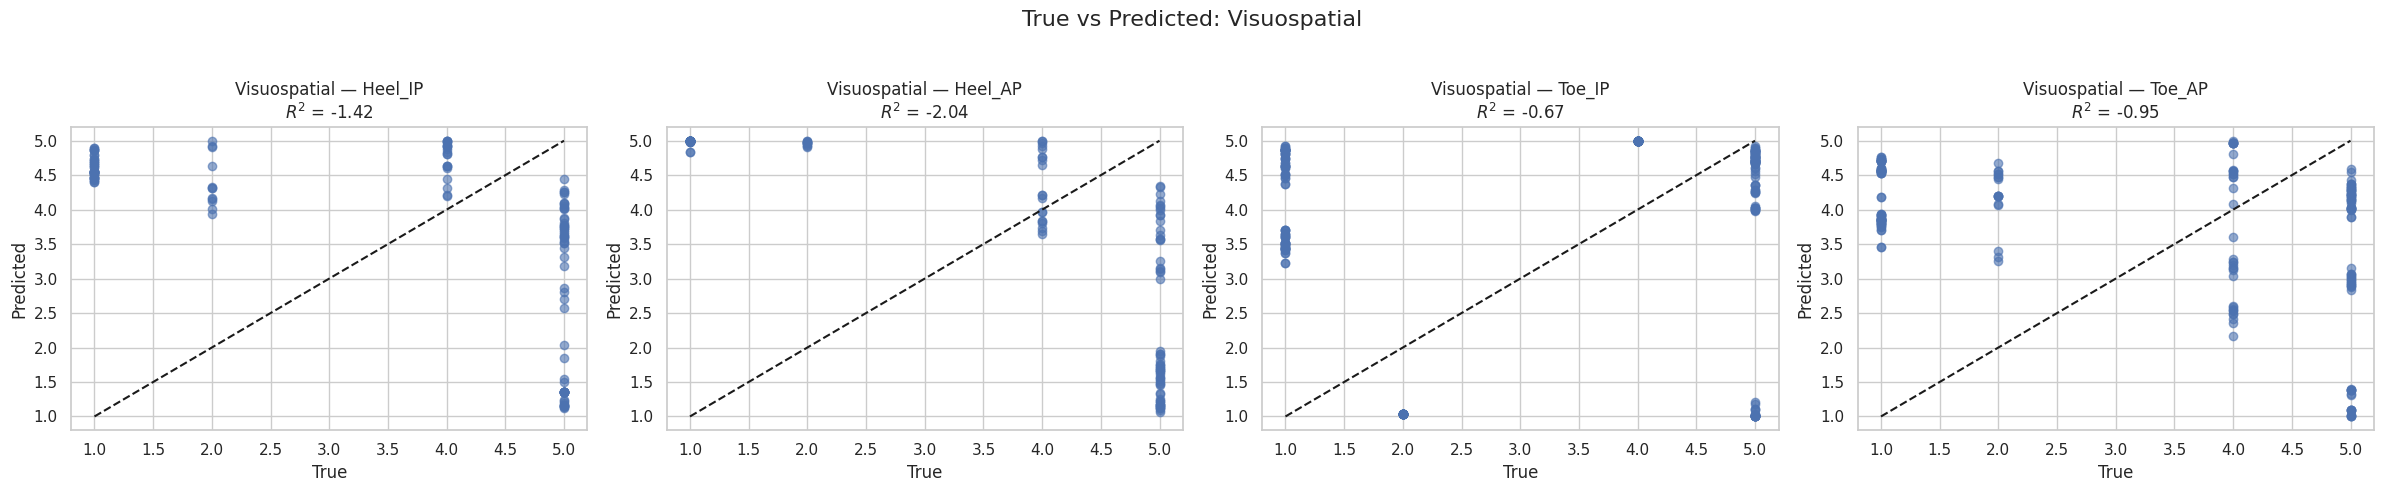

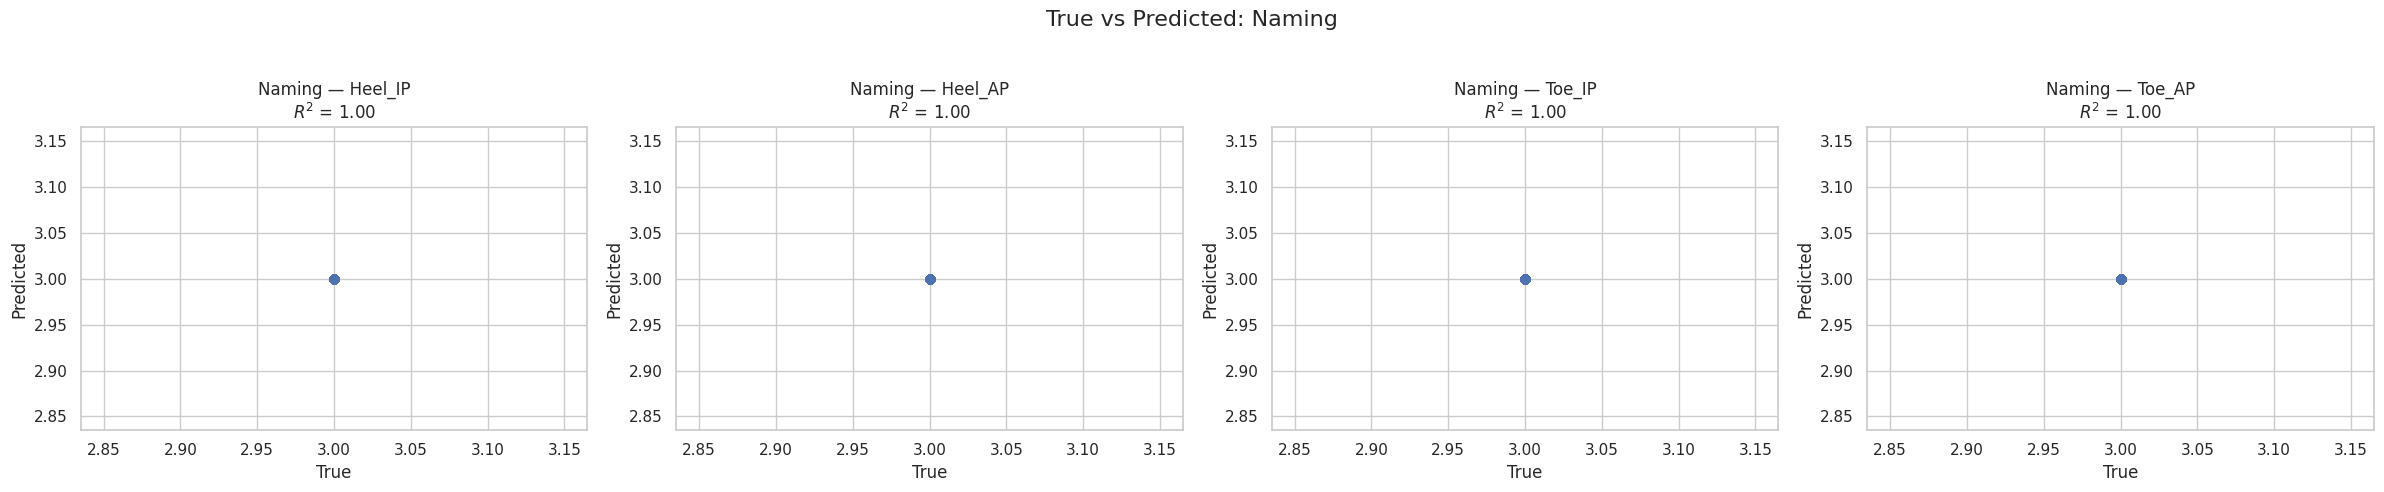

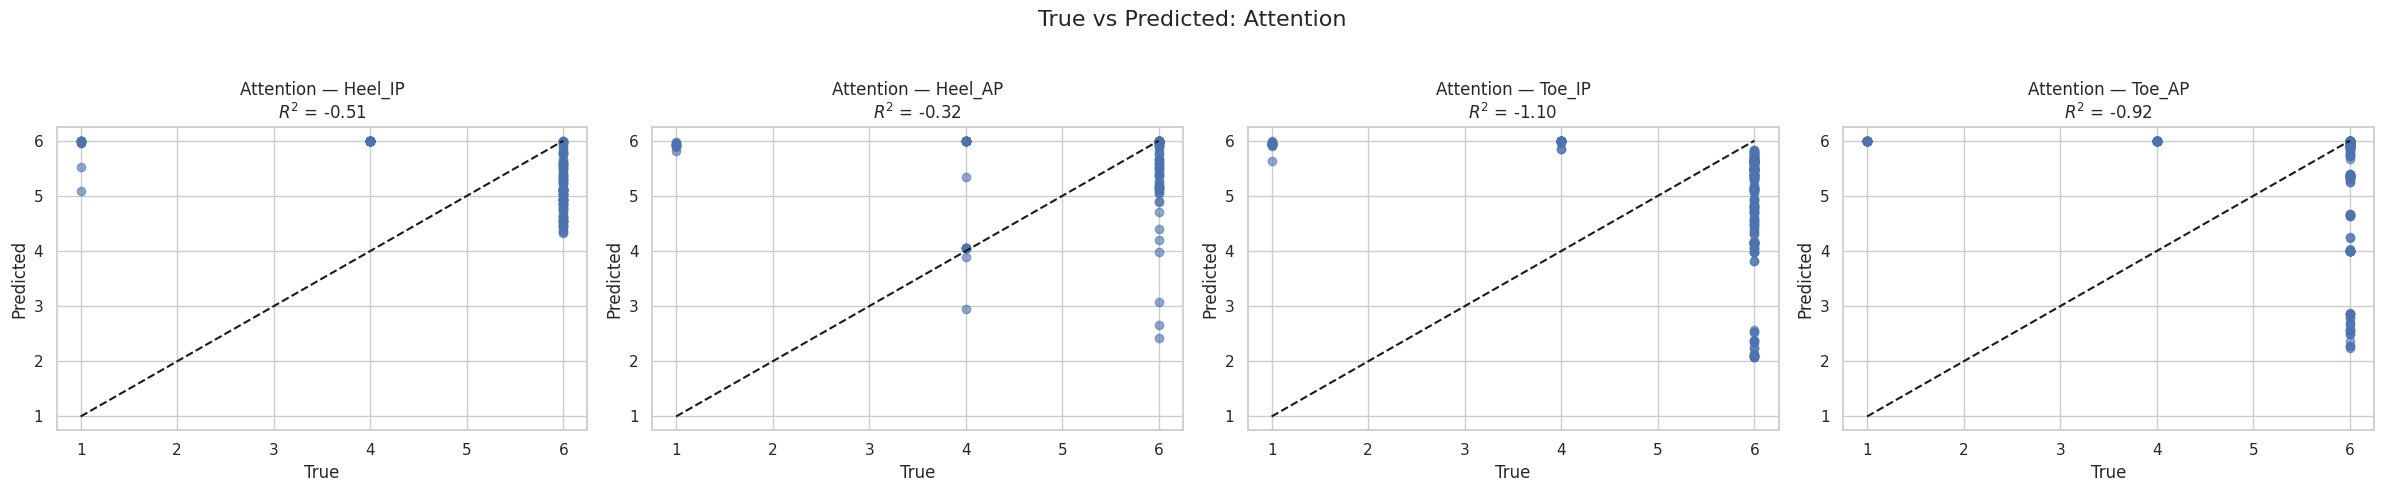

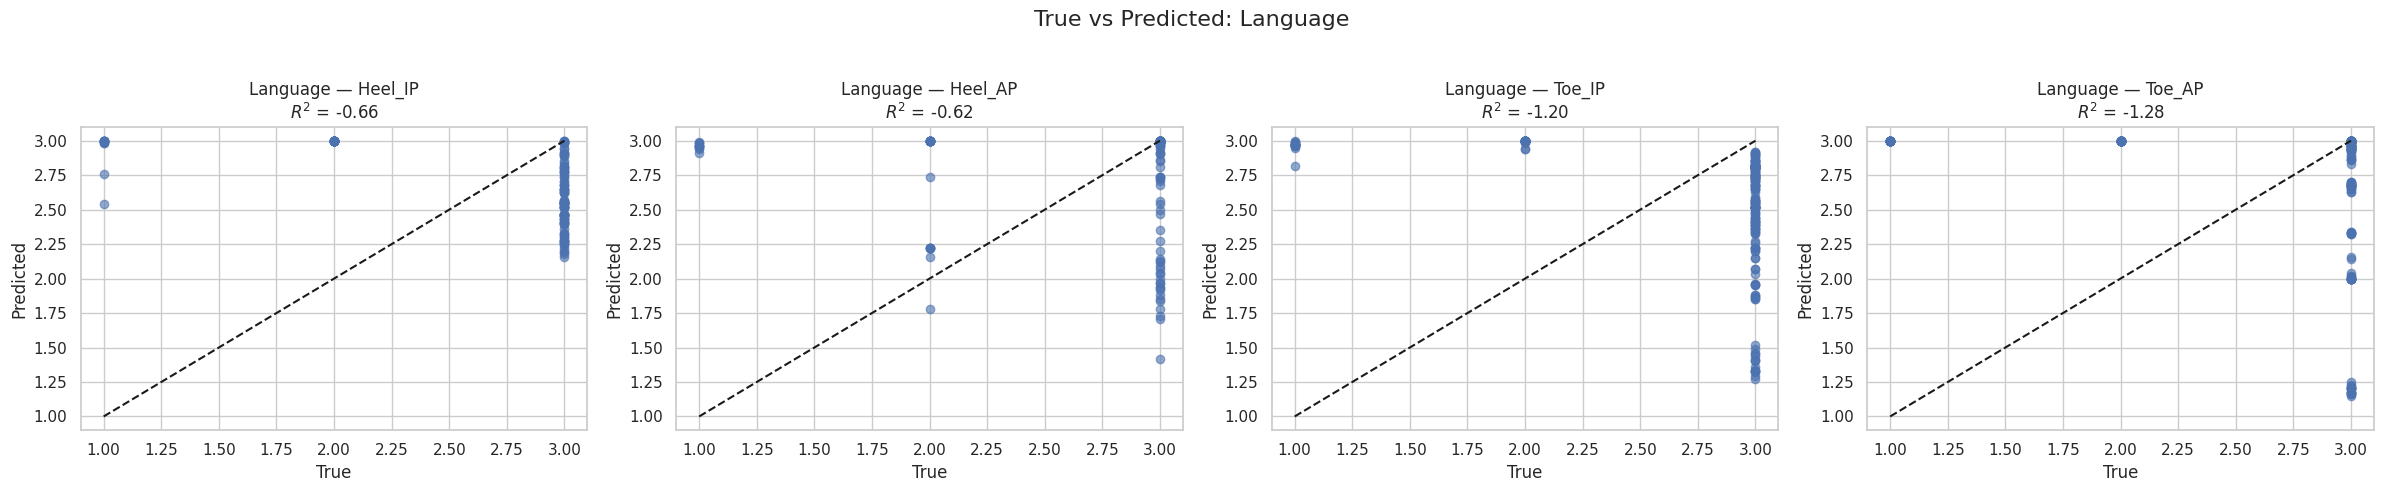

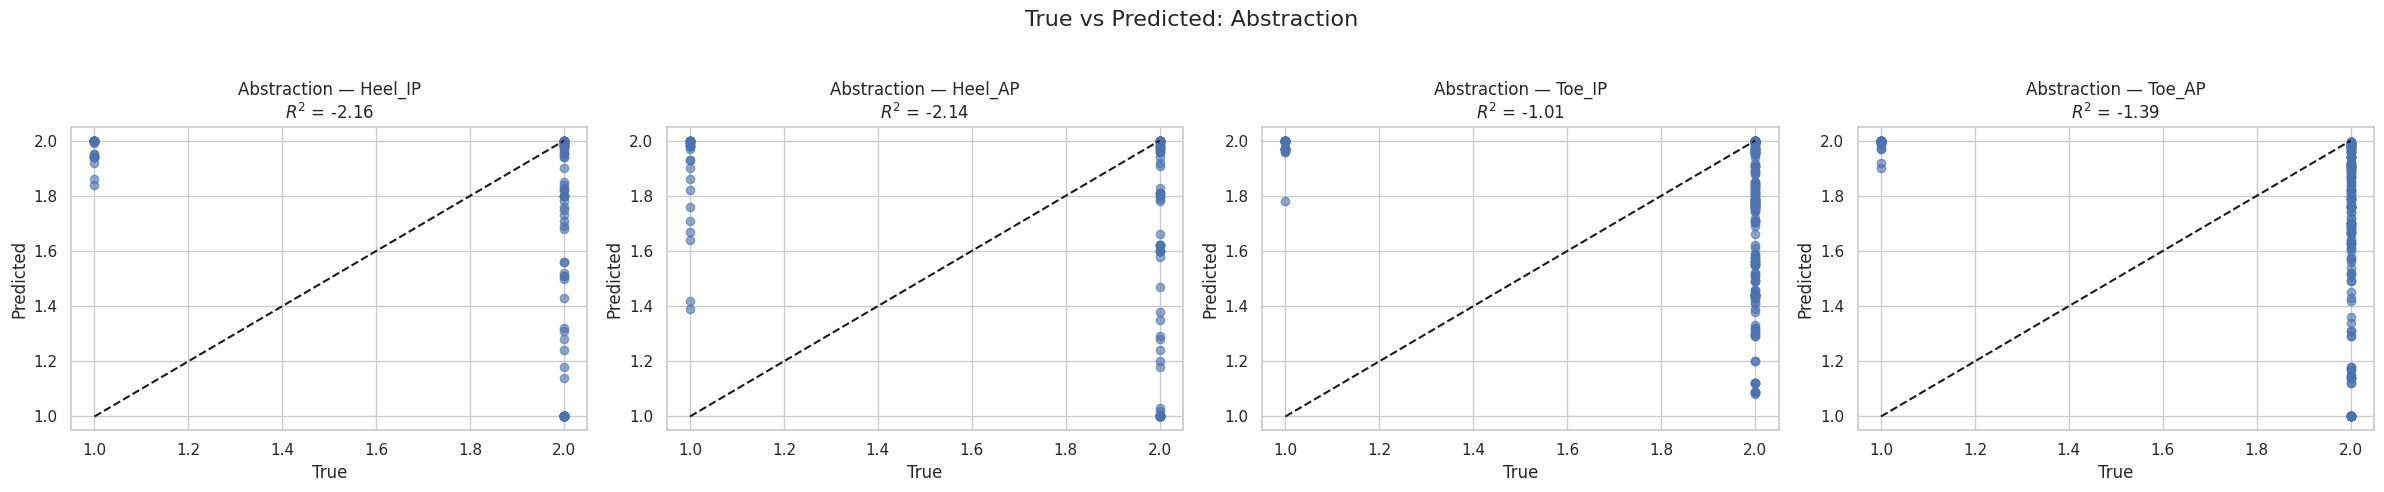

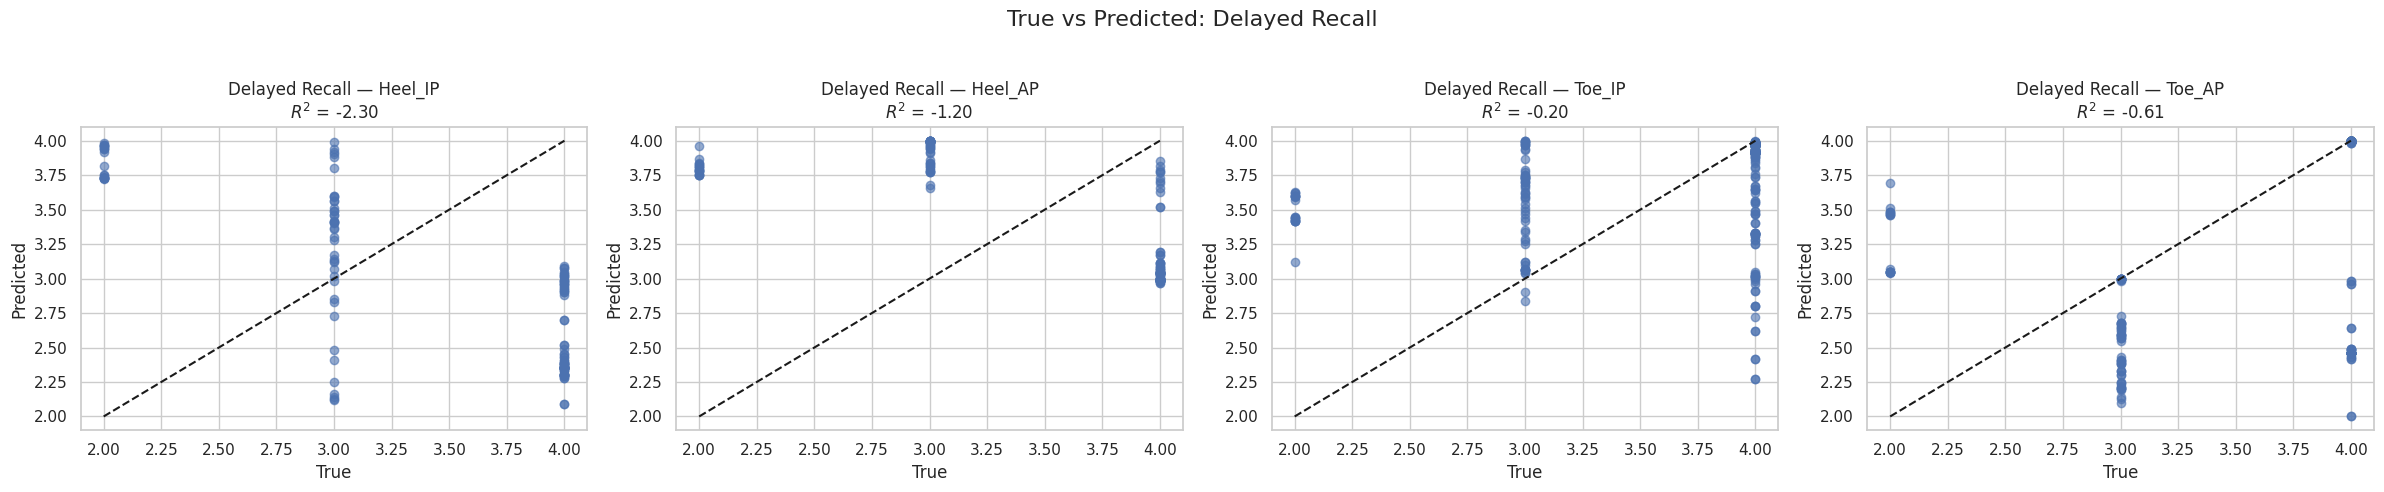

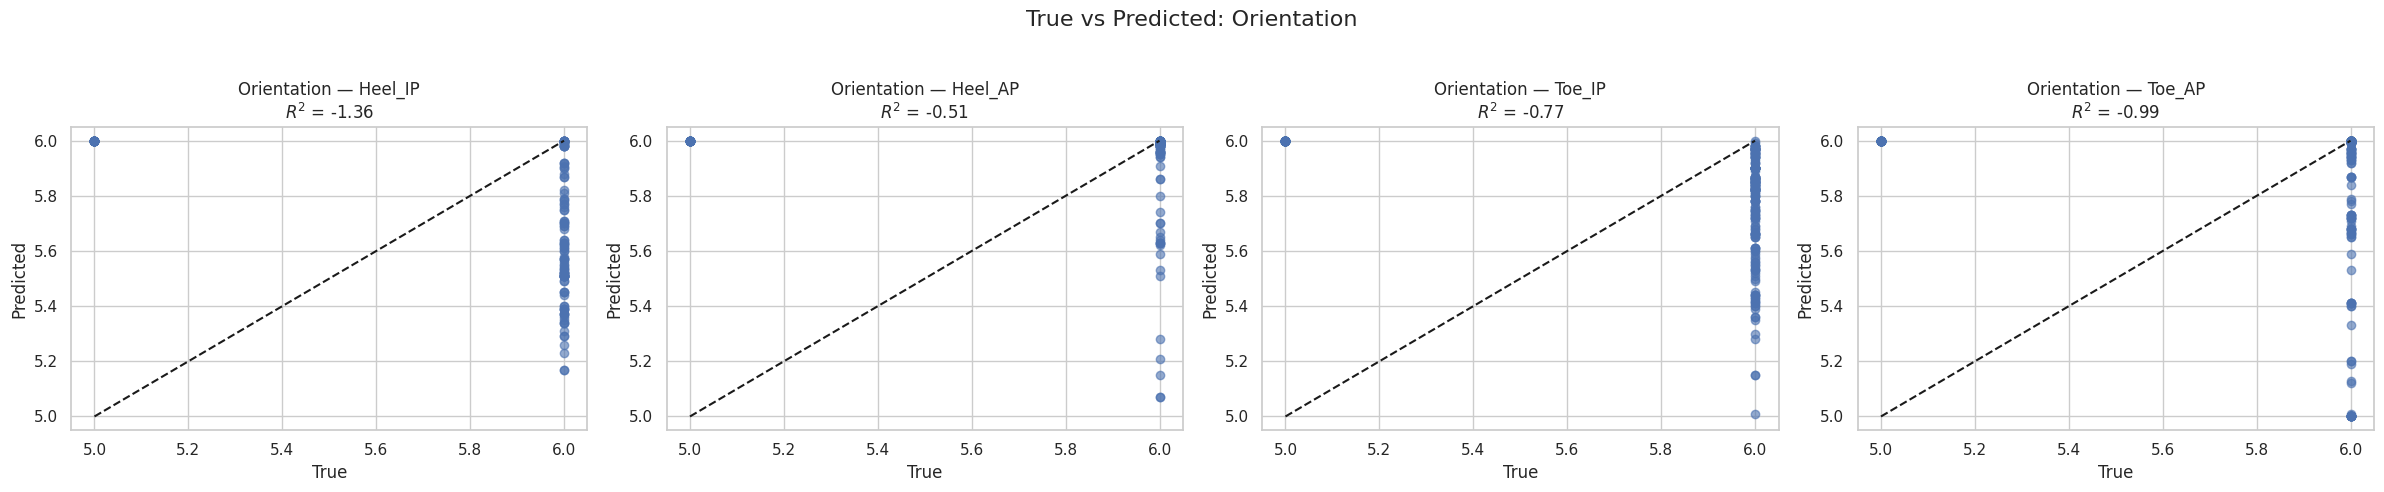

In [ ]:
plot_loso_predictions_grouped_by_dataset(results)
